# YOLO-Based White Blood Cell Detection and Classification for the Trusttii Competition

This notebook provides a detailed and professional workflow for the **Trusttii Competition**, focused on training the **YOLO (You Only Look Once)** object detection model to detect and classify white blood cells. It includes **data preparation** steps such as cleaning, augmentation, and normalization to ensure high-quality inputs for the model.

The training process leverages **manual checkpointing**, where the model is saved at various stages and reloaded in subsequent runs to continue training. This approach enables flexibility and careful performance tuning over multiple sessions. This notebook represents the final stage of the workflow, incorporating the **best-performing model** from the training process. Finally, the trained model is saved, making it ready for further use.

**Note:** Due to the terms and conditions outlined by Trustti, I am unable to share the dataset directly. As a result, I have removed the access to the ID on gdown for downloading the dataset. I hope you understand the necessity of adhering to these guidelines.

## First, We install the Required libraries

In [1]:
# Install necessary libraries
!pip install ultralytics pandas matplotlib tqdm

# Import essential libraries
import os
import zipfile
import pandas as pd
import numpy as np
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from shutil import copyfile
from ultralytics import YOLO

# Set random seed for reproducibility
np.random.seed(42)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.9/906.9 kB 16.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Then, we install Gdown and get the Dataset From Google Drive

In [2]:
! conda install -y gdown  #Intsalling Gdown via conda


!gdown --id  1vLyASKB0LoW7gWy3CvKvwVx-9B-34hhd #training csv file
!gdown --id  10VnyXaPPNiU7yt25ie1K9mFwuiIAB0n5 #testing csv file
!gdown --id  1UV96qs-GWSdtzq-x4_p5OWoPz9Djjup5 #images.zip file



/bin/bash: line 1: conda: command not found
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1vLyASKB0LoW7gWy3CvKvwVx-9B-34hhd
To: /kaggle/working/cytologia-data-train_1732098640162.csv
100%|███████████████████████████████████████| 1.82M/1.82M [00:00<00:00, 179MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10VnyXaPPNiU7yt25ie1K9mFwuiIAB0n5
To: /kaggle/working/cytologia-data-1732098640162_test_.csv
100%|████████████████████████████████████████| 473k/473k [00:00<00:00, 97.4MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140:

Now that the dataset has been downloaded, the next step is to extract the `images.zip` file and verify the presence of both the training and testing CSV files to ensure everything is set up correctly for data preparation.

## **Dataset Extraction and Verification**

In [3]:
# Define paths
images_zip_path = "images.zip"
images_folder_path = "images"
training_csv_path = "cytologia-data-train_1732098640162.csv"
testing_csv_path = "cytologia-data-1732098640162_test_.csv"

# Extract images.zip
if os.path.exists(images_zip_path):
    print("Extracting images.zip...")
    with zipfile.ZipFile(images_zip_path, 'r') as zip_ref:
        zip_ref.extractall(images_folder_path)
    os.remove(images_zip_path) #remove the zip file after the extraction
else:
    print(f"Error: {images_zip_path} does not exist.")

# Check if images folder is extracted
if os.path.exists(images_folder_path):
    print("Images folder successfully extracted.")
else:
    print("Error: Images folder not found after extraction.")

# Check if training.csv exists
if os.path.exists(training_csv_path):
    print("Training CSV file is present.")
else:
    print("Error: Training CSV file is missing.")

# Check if testing.csv exists
if os.path.exists(testing_csv_path):
    print("Testing CSV file is present.")
else:
    print("Error: Testing CSV file is missing.")

print("Preparation checks complete. Proceeding to the next steps...")


Extracting images.zip...
Images folder successfully extracted.
Training CSV file is present.
Testing CSV file is present.
Preparation checks complete. Proceeding to the next steps...


# Data Preparation and Cleaning
Now that the data checking is complete, we can begin the preparation phase.

In this section, the dataset will undergo a series of **preprocessing steps** to ensure it's properly **formatted** and ready for training the YOLO model.

## **1. Organizing the `images` Folder**

This phase involves ensuring the `images` folder is organized and cleaned, so it’s ready for use in model training or further analysis.s:**

1. **Check if the `images` folder exists**:
    - Ensure that the folder where your image files are located exists.
    - If it doesn't exist, a message will be printed to inform you.
2. **Detect and resolve nested directories**:
    - If there are subdirectories inside the `images` folder, recursively move all image files (`.jpg`, `.jpeg`, `.png`, etc.) to the main `images` folder.
    - After moving the image files, the empty subdirectories will be deleted.
3. **Remove non-image files**:
    - Any non-image files in the main `images` folder will be removed to ensure that only image files are present.
4. **Provide status updates**:
    - During the process, status updates will be displayed for tracking, and any errors will be gracefully handled.paration.ssed.

In [4]:
def clean_images_folder(images_folder):
    try:
        # Check if images folder exists
        if not os.path.exists(images_folder):
            print(f"Error: {images_folder} does not exist.")
            return

        # Check and handle nested folders recursively
        def move_images_to_main(folder):
            for root, dirs, files in os.walk(folder):
                for file in files:
                    file_path = os.path.join(root, file)
                    if file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif")):
                        shutil.move(file_path, images_folder)
                # Add subfolders to the queue for further processing
                for sub_dir in dirs:
                    move_images_to_main(os.path.join(root, sub_dir))

        print("Checking for nested folders and moving images to the main images folder...")
        nested_content = [os.path.join(images_folder, item) for item in os.listdir(images_folder)]
        nested_folders = [item for item in nested_content if os.path.isdir(item)]

        for folder in nested_folders:
            move_images_to_main(folder)
            shutil.rmtree(folder)  # Remove the empty nested folder

        # Remove non-image files from the main images folder
        print("Cleaning the images folder to contain only image files...")
        for item in os.listdir(images_folder):
            item_path = os.path.join(images_folder, item)
            if os.path.isfile(item_path) and not item.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif")):
                print(f"Removing non-image file: {item}")
                os.remove(item_path)

        print("Images folder is cleaned and ready.")

    except Exception as e:
        print(f"An error occurred while cleaning the images folder: {e}")

# Call the function
clean_images_folder(images_folder_path)


Checking for nested folders and moving images to the main images folder...
Cleaning the images folder to contain only image files...
Images folder is cleaned and ready.


### **1.1 Image Integrity Repair with Pillow:**

The `repair_image` function uses Pillow to check each image's integrity. This step is necessary to ensure that corrupted images don't interfere with the data processing workflow. If valid, it reopens and saves the image to fix minor corruption. If corrupted, it skips the image and prints a message. The `process_images` function applies this to all JPEG files in the folder, ensuring corrupted images are excluded from further processing.

In [5]:
def repair_image(image_path):
    try:
        # Open the image and verify if it is valid
        img = Image.open(image_path)
        img.verify()  # Verify the integrity of the image
        
        # If the image is valid, reopen it and save it back to the same path
        img = Image.open(image_path)  # Reopen the image to avoid corruption issues
        img.save(image_path)  # Save the image, this will overwrite the original file
        return True  # Return True if the image was repaired
        
    except (IOError, SyntaxError) as e:
        # In case of a corrupted image, print a message and continue
        print(f"Skipped corrupted image: {image_path}")
        return False  # Return False if the image was skipped

def process_images(input_folder):
    repaired_count = 0
    print("Repairing images...")
    
    for filename in os.listdir(input_folder):
        image_path = os.path.join(input_folder, filename)
        
        # Process only JPEG files
        if filename.lower().endswith('.jpg') or filename.lower().endswith('.jpeg'):
            if repair_image(image_path):
                repaired_count += 1

    print(f"Repairing done. {repaired_count} image(s) repaired.")

process_images(images_folder_path)

Repairing images...
Repairing done. 69168 image(s) repaired.


## **2. Clean the Training CSV File**
Once the images folder is organized, we will proceed to clean and preprocess the CSV file.

### **2.1 Step 1: **Import Libraries and Define Valid Classes****.

In [6]:
import pandas as pd
import os

# Valid class labels (abbreviations)
valid_classes = [
    'PNN', 'LAM3', 'Lysee', 'LyB', 'MO', 'LLC', 'MBL', 'LGL', 'EO',
    'Thromb', 'Er', 'B', 'M', 'LY', 'MM', 'LF', 'MoB', 'PM', 'BA',
    'LH_lyAct', 'LM', 'LZMG', 'SS'
]

### **2.2 Step 2: **Check if CSV Exists****

We ensure that the file exists before proceeding. And we load it.

In [7]:
if not os.path.exists(training_csv_path):
    print(f"Error: {training_csv_path} does not exist.")
else:
    # Load the CSV if it exists
    print("Loading training CSV file...")
    df = pd.read_csv(training_csv_path)
    print("Initial DataFrame Info:")
    print(df.info())


Loading training CSV file...
Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52748 entries, 0 to 52747
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NAME    52748 non-null  object
 1   x1      52748 non-null  int64 
 2   y1      52748 non-null  int64 
 3   x2      52748 non-null  int64 
 4   y2      52748 non-null  int64 
 5   class   52748 non-null  object
dtypes: int64(4), object(2)
memory usage: 2.4+ MB
None


### **2.3 Step 3: **Check for Missing Columns****

We Ensure all expected columns (`NAME`, `x1`, `y1`, `x2`, `y2`, `class`) are present.

In [8]:
required_columns = ['NAME', 'x1', 'y1', 'x2', 'y2', 'class']

missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"Error: Missing required columns: {', '.join(missing_columns)}")
else:
    print("All required columns are present.")


All required columns are present.


### **2.4 Step 4: **Handle Missing Data****

We also ensure that no missing data exists for essential columns like `NAME`, `x1`, `y1`, `x2`, `y2`, and `class`.

In [9]:
print("Checking for missing data in crucial columns...")
missing_data = df[df[['NAME', 'x1', 'y1', 'x2', 'y2', 'class']].isnull().any(axis=1)]
if not missing_data.empty:
    print("Rows with missing data detected:")
    print(missing_data)
    print("Removing rows with missing essential data...")
    df = df.dropna(subset=['NAME', 'x1', 'y1', 'x2', 'y2', 'class'])
else:
    print("No missing data detected in crucial columns. Everything is good!")

Checking for missing data in crucial columns...
No missing data detected in crucial columns. Everything is good!


### 2.5 Step 5: Validate Bounding Box Coordinates

In here, we must make sure that `x1`, `y1` are smaller than or equal to `x2`, `y2` (i.e., no inverted bounding boxes).

Inverted bounding boxes occur when the top-left corner (represented by `x1`, `y1`) is lower or to the right of the bottom-right corner (`x2`, `y2`). These inverted boxes can lead to incorrect bounding box definitions, which might cause issues during training or object detection tasks. To ensure accurate detection, we need to guarantee that the top-left coordinates are always smaller than or equal to the bottom-right coordinates.nates.

In [10]:
print("Validating bounding box coordinates...")

# Check for invalid bounding box coordinates (x1 <= x2 and y1 <= y2)
invalid_bbox = df[(df['x1'] > df['x2']) | (df['y1'] > df['y2'])]
if not invalid_bbox.empty:
    print("Rows with invalid bounding box coordinates detected:")
    print(invalid_bbox)
    print("Removing rows with invalid bounding box coordinates...")
    df = df[(df['x1'] <= df['x2']) & (df['y1'] <= df['y2'])]
else:
    print("All bounding box coordinates are valid. Everything is good!")

Validating bounding box coordinates...
All bounding box coordinates are valid. Everything is good!


### **2.6 Step 6: **Check for Invalid 'NAME' Values****




This step checks for invalid `'NAME'` values in the dataset by identifying rows where the `'NAME'` column is either missing (null) or contains only whitespace characters. Rows with invalid `'NAME'` values are detected and removed to ensure that each entry has a valid image name, preventing any issues during further data processing or model training.

In [11]:
print("Checking for invalid 'NAME' values...")

# Checking for empty or missing 'NAME' values
invalid_names = df[df['NAME'].isnull() | df['NAME'].str.strip().eq('')]
if not invalid_names.empty:
    print("Rows with invalid 'NAME' values detected:")
    print(invalid_names)
    print("Removing rows with invalid 'NAME' values...")
    df = df[~df['NAME'].isnull()]
    df = df[df['NAME'].str.strip().ne('')]
else:
    print("All 'NAME' values are valid. Everything is good!")

Checking for invalid 'NAME' values...
All 'NAME' values are valid. Everything is good!


### **2.7 Step 7: **Validate Class Labels****

This step validates the `'class'` labels in the dataset by checking if each label is part of the list we created earlier that contains all the valid classes. Any rows with invalid class labels (those not found in this list) are detected and removed to ensure the integrity of the dataset. This ensures that only recognized and valid class labels are present, which is crucial for accurate model training and predictions.

In [12]:
print("Validating 'class' labels...")

# Check for invalid class labels (not in valid_classes)
invalid_classes = df[~df['class'].isin(valid_classes)]
if not invalid_classes.empty:
    print("Rows with invalid 'class' labels detected:")
    print(invalid_classes)
    print("Removing rows with invalid 'class' labels...")
    df = df[df['class'].isin(valid_classes)]
else:
    print("All 'class' labels are valid. Everything is good!")

Validating 'class' labels...
All 'class' labels are valid. Everything is good!


### **2.8 Step 8: **Remove Duplicate White Blood Cells Based on 'NAME' and Coordinates****

In this step, we identify and remove duplicate rows where both the **`NAME`** and the **bounding box coordinates** (`x1`, `y1`, `x2`, `y2`) are identical. If a row has the same image name and the same bounding box coordinates, it represents the same **white blood cell**, which we consider a duplicate. Removing these duplicates ensures each white blood cell is counted only once, preventing inaccuracies in the dataset.g.

In [13]:
print("Checking for duplicates based on 'NAME' and bounding box coordinates...")

# Define the subset of columns to check for duplicates
duplicate_columns = ['NAME', 'x1', 'y1', 'x2', 'y2']

# Identify duplicate rows based on 'NAME' and coordinates
duplicates = df[df.duplicated(subset=duplicate_columns)]

if not duplicates.empty:
    print("Duplicate rows detected (same 'NAME' and bounding box coordinates):")
    print(duplicates)
    print("Removing duplicates...")
    df = df.drop_duplicates(subset=duplicate_columns)
    print("Duplicates removed successfully.")
else:
    print("No duplicate rows found. Everything is good!")

Checking for duplicates based on 'NAME' and bounding box coordinates...
No duplicate rows found. Everything is good!


### **2.9 Step 9: **Validate Numeric Columns and Remove Extreme Values****-

This step ensures that the `'x1'`, `'y1'`, `'x2'`, and `'y2'` columns contain valid numeric values by attempting to **convert** any invalid entries (e.g., strings or non-numeric values) to `NaN` using **type casting**. This conversion allows us to easily detect and remove invalid data, ensuring that only valid numeric values remain. Additionally, it checks for **extreme values** in the coordinates (such as negative values), which are not valid for bounding boxes. Any rows with extreme values are detected and removed to maintain the integrity of the dataset and ensure that only valid coordinate data remains for further processing.


In [14]:
print("Validating numeric columns...")

# Ensure x1, y1, x2, y2 are numeric and count invalid rows
invalid_before = df.shape[0]
for col in ['x1', 'y1', 'x2', 'y2']:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Converts invalid entries to NaN

# Remove rows with NaN after conversion
df = df.dropna(subset=['x1', 'y1', 'x2', 'y2'])
invalid_after = df.shape[0]
invalid_removed = invalid_before - invalid_after

if invalid_removed > 0:
    print(f"Invalid (non-numeric) rows found and removed: {invalid_removed}")
else:
    print("No invalid (non-numeric) rows found.")

# Check for extreme values (negative coordinates)
print("Checking for extreme values in coordinates...")
extreme_values = df[(df['x1'] < 0) | (df['y1'] < 0) | (df['x2'] < 0) | (df['y2'] < 0)]
extreme_count = extreme_values.shape[0]

if extreme_count > 0:
    print(f"Rows with extreme (negative) values found: {extreme_count}")
    print("Removing rows with extreme values...")
    df = df[(df['x1'] >= 0) & (df['y1'] >= 0) & (df['x2'] >= 0) & (df['y2'] >= 0)]
    print(f"Extreme value rows removed: {extreme_count}")
else:
    print("No extreme (negative) coordinate values found.")

print(f"Final dataset size: {df.shape[0]} rows.")

Validating numeric columns...
No invalid (non-numeric) rows found.
Checking for extreme values in coordinates...
Rows with extreme (negative) values found: 356
Removing rows with extreme values...
Extreme value rows removed: 356
Final dataset size: 52392 rows.


### **2.10 Step 10: **Overwrite the Original CSV with Cleaned Data****-

This step saves the cleaned DataFrame back to the original CSV file, overwriting the existing data. By doing so, we ensure that the modifications (such as removed duplicates, invalid values, or missing data) are reflected in the original file, keeping the dataset up-to-date and ready for the next stages of processandg or model training.

In [15]:
# Save the cleaned DataFrame back to the original CSV file
print(f"Saving cleaned data back to the original CSV file: {training_csv_path}...")
df.to_csv(training_csv_path, index=False)
print(f"Original CSV file has been overwritten with cleaned data: {training_csv_path}")

Saving cleaned data back to the original CSV file: cytologia-data-train_1732098640162.csv...
Original CSV file has been overwritten with cleaned data: cytologia-data-train_1732098640162.csv


### **2.11 Step 11: **Randomly Check Bounding Boxes and Image-Label Correlation**** 


In this step, we'll perform a random check to quickly demonstrate that the bounding boxes are labeled and positioned correctly within the images. This is just a basic visual check to ensure the dataset and the images are aligned and that the bounding boxes correspond to the correct regions. Please note, this step is purely for demonstration purposes and helps to visually verify the correlation between the image and its bounding box lae changes.e changes.

Randomly sampled rows for bounding box validation:


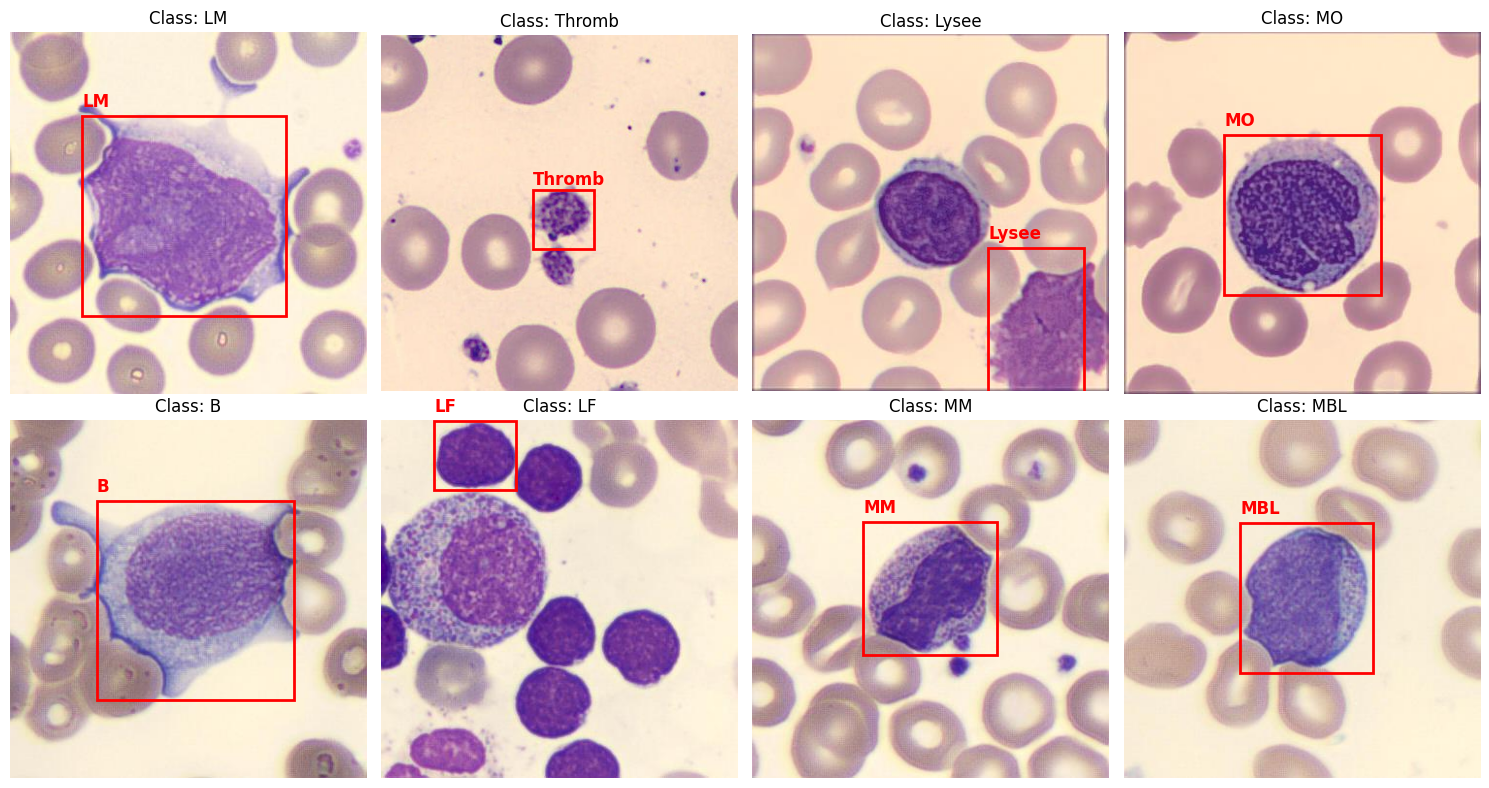

In [16]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os


# Randomly sample 8 rows from the DataFrame for visual checks
sampled_df = df.sample(n=8, random_state=17)

print("Randomly sampled rows for bounding box validation:")

# Set up the plot
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # 2x4 grid for image display
axes = axes.flatten()

for i, (idx, row) in enumerate(sampled_df.iterrows()):
    img_filename = row['NAME']  # Image filename from the 'NAME' column
    img_path = os.path.join(images_folder_path, img_filename)  # Full path to the image
    class_label = row['class']
    x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']

    try:
        # Open the image
        img = Image.open(img_path)
        
        # Plot the image
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        
        # Create a rectangle for the bounding box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add the class label on top of the bounding box
        ax.text(x1, y1 - 10, class_label, color='red', fontsize=12, fontweight='bold')

        ax.set_title(f"Class: {class_label}")
    except Exception as e:
        print(f"Error with image {img_path}: {e}")

# Display the images with bounding boxes and labels
plt.tight_layout()
plt.show()


**Getting only the images in the training csv**

Before we start image preprocesing, we must make a folder that contains only the images addressed in the training csv file 

In [17]:
import os
import shutil
import pandas as pd

# Paths
images_folder_path = 'images'  # Path to the folder containing all images
training_csv_path = 'cytologia-data-train_1732098640162.csv'  # Path to the training CSV file
yolo_training_val_images = 'yolo_training_val_images'  # Destination folder for all images listed in the CSV

# Ensure the output folder exists
os.makedirs(yolo_training_val_images, exist_ok=True)

# Read the CSV and extract unique image names
csv_data = pd.read_csv(training_csv_path)
images_in_csv = set(csv_data['NAME'].unique())

# Copy images listed in the CSV to the destination folder
missing_images = []
for image_name in images_in_csv:
    src_path = os.path.join(images_folder_path, image_name)
    dest_path = os.path.join(yolo_training_val_images, image_name)
    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
    else:
        missing_images.append(image_name)

# Verify and report
if missing_images:
    print(f"Warning: {len(missing_images)} images listed in the CSV are missing from the source folder.")
else:
    print("All images listed in the CSV are successfully copied to the  yolo_training_val_images  folder.")

print(f"Copied {len(images_in_csv) - len(missing_images)} images to {yolo_training_val_images}.")

All images listed in the CSV are successfully copied to the  yolo_training_val_images  folder.
Copied 48415 images to yolo_training_val_images.


**Now We check if  yolo_training_val_images  folder contains all the images listed in the csv**

In [18]:
# Read the updated CSV
csv_data = pd.read_csv(training_csv_path)

# Get image names from the folder
folder_images = set(os.listdir(yolo_training_val_images))

# Get unique image names from the CSV
csv_images = set(csv_data['NAME'])

# Check for missing images
missing_in_folder = csv_images - folder_images
missing_in_csv = folder_images - csv_images

if missing_in_folder:
    print(f"Missing in folder: {len(missing_in_folder)} images: {missing_in_folder}")
else:
    print("All CSV images are present in the folder.")

if missing_in_csv:
    print(f"Missing in CSV: {len(missing_in_csv)} images: {missing_in_csv}")
else:
    print("All folder images are accounted for in the CSV.")

All CSV images are present in the folder.
All folder images are accounted for in the CSV.


## **3. Image Preprocessing**

The image preprocessing stage ensures the dataset is clean, consistent, and optimized for YOLO model training. This step focuses on cropping, resizing, normalizing, and augmenting the images to improve model performance and generalization.

**Goals of Image Preprocess**tes.
- **Resizing**: Standardize image size (e.g., 416x416 pixels) for YOLO input.
- **Normalization**: Scale pixel values to stabilize and speed up training.
- **Augmentation**: Enhance variability with techniques like flipping, rotation, and color adjustments, while also balancing class distributions. Domain-specific augmentations will also be applied to suit medical imaging data.

### **3.1 Step 1 : Resizing**
Resizing ensures that all images are of a consistent size, which is crucial for deep learning models like YOLO. By standardizing the input size (e.g., 416x416 pixels), we ensure uniformity and improve the efficiency of training, as YOLO requires fixed-size input images.

In [19]:
import os
import pandas as pd
from PIL import Image

# Define the target size (416x416 for YOLO)
target_size = (416, 416)
new_width, new_height = target_size

# Load the CSV containing bounding box data
df = pd.read_csv(training_csv_path)

# Initialize counters and a set to track resized images
resized_count = 0
errors = 0
processed_images = set()

# Start resizing and coordinate adjustment process
print("Starting resizing and bounding box adjustment process...")

adjusted_rows = []
for _, row in df.iterrows():
    image_name = row['NAME']
    image_path = os.path.join(yolo_training_val_images, image_name)

    # Skip already resized images
    if image_name in processed_images:
        adjusted_rows.append({
            'NAME': image_name,
            'x1': row['x1'], 'y1': row['y1'],
            'x2': row['x2'], 'y2': row['y2'],
            'class': row['class']
        })
        continue

    if not os.path.exists(image_path):
        print(f"Error: Image {image_name} not found. Skipping...")
        errors += 1
        continue

    try:
        with Image.open(image_path) as img:
            # Get original dimensions
            original_width, original_height = img.size

            # Resize the image
            resized_img = img.resize(target_size)
            resized_img.save(image_path)

            # Calculate scale factors
            scale_x = new_width / original_width
            scale_y = new_height / original_height

            # Adjust bounding box coordinates
            x1 = row['x1'] * scale_x
            y1 = row['y1'] * scale_y
            x2 = row['x2'] * scale_x
            y2 = row['y2'] * scale_y

            # Ensure the bounding box coordinates are within the resized image dimensions
            x1 = max(0, min(x1, new_width))
            y1 = max(0, min(y1, new_height))
            x2 = max(0, min(x2, new_width))
            y2 = max(0, min(y2, new_height))

            # Save adjusted row
            adjusted_rows.append({
                'NAME': image_name,
                'x1': x1, 'y1': y1,
                'x2': x2, 'y2': y2,
                'class': row['class']
            })

            resized_count += 1
            processed_images.add(image_name)  # Mark image as processed
    except Exception as e:
        print(f"Error resizing image {image_name}: {e}")
        errors += 1

# Save the adjusted bounding box data to the original CSV (overwrite)
adjusted_df = pd.DataFrame(adjusted_rows)
adjusted_df.to_csv(training_csv_path, index=False)

# Final summary
print("\nResizing and bounding box adjustment completed!")
print(f"Total images resized: {resized_count}")
if errors == 0:
    print("No errors found.")
else:
    print(f"Total errors encountered: {errors}")
print(f"Adjusted CSV saved to: {training_csv_path}")

Starting resizing and bounding box adjustment process...

Resizing and bounding box adjustment completed!
Total images resized: 48415
No errors found.
Adjusted CSV saved to: cytologia-data-train_1732098640162.csv


### **3.2 Step 2 : Pixel Normalization**
Pixel Normalization transforms the pixel values of images to a range between 0 and 1. This standardization makes the input data more consistent and helps the neural network converge faster by reducing the risk of large gradients and ensuring that the model learns effectively.

In [20]:
import os
import numpy as np
from PIL import Image

# Get all image files from the training_images folder
image_files = [f for f in os.listdir(yolo_training_val_images) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

# Initialize counter for normalized images
normalized_count = 0
errors = 0

# Start normalization process
print("Starting the pixel normalization process...")

for img_file in image_files:
    img_path = os.path.join(yolo_training_val_images, img_file)

    try:
        # Open the image
        with Image.open(img_path) as img:
            # Convert the image to a NumPy array
            img_array = np.array(img)
            
            # Normalize the pixel values to the range [0, 1]
            img_array = img_array / 255.0
            
            # Convert the normalized array back to an image
            normalized_img = Image.fromarray((img_array * 255).astype(np.uint8))
            
            # Save the normalized image back to the same folder
            normalized_img.save(img_path)
            normalized_count += 1
    except Exception as e:
        print(f"Error processing image {img_file}: {e}")
        errors += 1

# Final summary
print("\nNormalization process completed!")
print(f"Total images normalized: {normalized_count}")
if errors == 0:
    print("No errors found.")
else:
    print(f"Total errors encountered: {errors}")


Starting the pixel normalization process...

Normalization process completed!
Total images normalized: 48415
No errors found.


### **3.4 Step 4 : Augmentation**
In this step, we will analyze the class distribution to identify any imbalances in the dataset. If certain classes dominate, we will apply augmentation techniques such as flipping, rotation, color adjustments, and blurring to enhance the variability of underrepresented classes. This process ensures a balanced dataset, improving the model's ability to generalize across all classes effectively.

**3.4.1 Analyze Class Distribution**

Create a bar chart to visualize the distribution of classes to identify dominant and underrepresented classes.

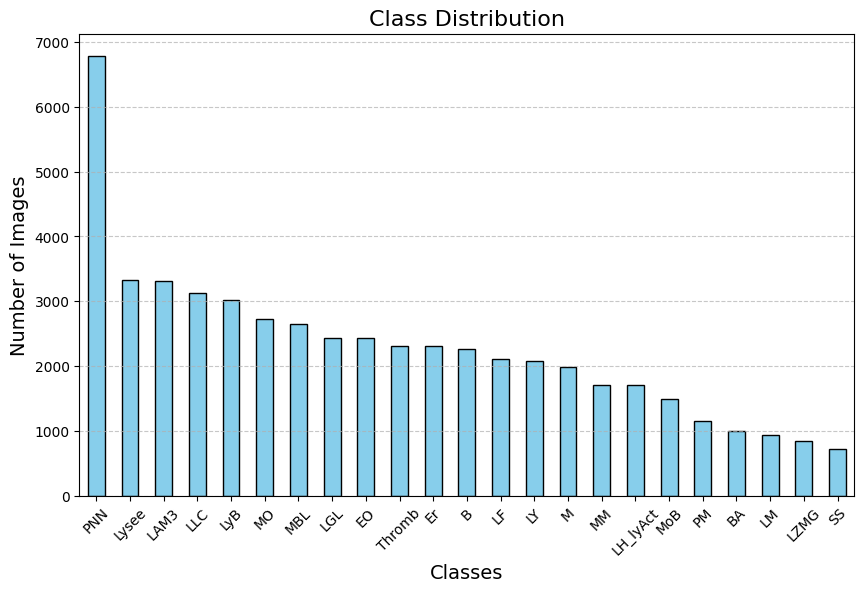

Class Distribution Summary:
class
PNN         6789
Lysee       3324
LAM3        3314
LLC         3127
LyB         3016
MO          2719
MBL         2651
LGL         2437
EO          2428
Thromb      2309
Er          2302
B           2260
LF          2108
LY          2080
M           1987
MM          1706
LH_lyAct    1700
MoB         1494
PM          1148
BA          1000
LM           940
LZMG         839
SS           714


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file containing class information
df = pd.read_csv(training_csv_path)

# Count the number of samples per class
class_counts = df['class'].value_counts()

# Plot the distribution of classes
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Class Distribution", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print a summary of class distribution
print("Class Distribution Summary:")
print(class_counts.to_string())

**Augmentation Strategy**
**What Will Happen:**

1. **Class Balancing**: The dataset will be adjusted so that each class has approximately the same number of images, based on the **average class size**.
   
2. **Over-Represented Classes**: For classes with more images than the average, some images will be randomly removed to match the average size.

3. **Under-Represented Classes**: For classes with fewer images, new images will be created using **augmentation techniques** (e.g., flips, rotations) to reach the target count.

4. **Saving Data**: The new, balanced dataset will be saved in a CSV file, and augmented images will be stored in the `training_images/` folder.

**Why:**
This ensures that the model trains on a more balanced dataset, preventing bias toward over-represented classes and improving its ability to generalize across all classes.fic nuances.


**3.4.2 Perform Class Balancing with Augmentation**

Apply augmentation techniques to underrepresented classes.

In [22]:
import os
import random
import pandas as pd
import numpy as np
from PIL import Image, ImageOps, ImageEnhance
import cv2
from shutil import copyfile

# Paths
balanced_images_folder = "balanced_images"
balanced_csv_path = "balanced_csv.csv"

# Load CSV
csv_data = pd.read_csv(training_csv_path)

# Ensure balanced_images folder exists
os.makedirs(balanced_images_folder, exist_ok=True)

# Function to apply transformations to bounding boxes
def transform_bbox(bbox, transformation, image_width, image_height):
    x1, y1, x2, y2 = bbox

    if transformation == "horizontal_flip":
        new_x1, new_x2 = image_width - x2, image_width - x1
        return new_x1, y1, new_x2, y2

    elif transformation == "vertical_flip":
        new_y1, new_y2 = image_height - y2, image_height - y1
        return x1, new_y1, x2, new_y2

    elif transformation == "rotation":
        # Rotate bounding box
        angle = random.uniform(-20, 20)
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2

        points = np.array([
            [x1, y1],
            [x2, y1],
            [x2, y2],
            [x1, y2]
        ])

        rotation_matrix = cv2.getRotationMatrix2D((image_width / 2, image_height / 2), angle, 1.0)
        rotated_points = cv2.transform(np.array([points]), rotation_matrix)[0]

        new_x1, new_y1 = rotated_points[:, 0].min(), rotated_points[:, 1].min()
        new_x2, new_y2 = rotated_points[:, 0].max(), rotated_points[:, 1].max()
        return int(new_x1), int(new_y1), int(new_x2), int(new_y2)

    elif transformation == "zoom":
        zoom_factor = random.uniform(1.1, 1.3)
        new_x1 = int(max(0, x1 * zoom_factor))
        new_y1 = int(max(0, y1 * zoom_factor))
        new_x2 = int(min(image_width, x2 * zoom_factor))
        new_y2 = int(min(image_height, y2 * zoom_factor))
        return new_x1, new_y1, new_x2, new_y2

    return x1, y1, x2, y2


# Function to apply augmentations
def augment_image(image_path, output_folder, bbox, class_name, counter):
    image = Image.open(image_path)
    augmented_data = []

    image_width, image_height = image.size

    # Horizontal Flip
    flipped = ImageOps.mirror(image)
    flipped_bbox = transform_bbox(bbox, "horizontal_flip", image_width, image_height)
    flipped_name = f"{os.path.splitext(os.path.basename(image_path))[0]}_aug{counter}_flip.jpg"
    flipped.save(os.path.join(output_folder, flipped_name))
    augmented_data.append((flipped_name, *flipped_bbox, class_name))

    # Vertical Flip
    flipped_vert = ImageOps.flip(image)
    flipped_vert_bbox = transform_bbox(bbox, "vertical_flip", image_width, image_height)
    flipped_vert_name = f"{os.path.splitext(os.path.basename(image_path))[0]}_aug{counter}_flipv.jpg"
    flipped_vert.save(os.path.join(output_folder, flipped_vert_name))
    augmented_data.append((flipped_vert_name, *flipped_vert_bbox, class_name))


    # Gaussian Noise
    noisy_image = np.array(image)
    noise = np.random.normal(0, 10, noisy_image.shape).astype(np.uint8)
    noisy_image = Image.fromarray(cv2.add(noisy_image, noise))
    noisy_name = f"{os.path.splitext(os.path.basename(image_path))[0]}_aug{counter}_noise.jpg"
    noisy_image.save(os.path.join(output_folder, noisy_name))
    augmented_data.append((noisy_name, *bbox, class_name))

    # Brightness
    enhancer = ImageEnhance.Brightness(image)
    bright_image = enhancer.enhance(random.uniform(0.8, 1.2))
    bright_name = f"{os.path.splitext(os.path.basename(image_path))[0]}_aug{counter}_bright.jpg"
    bright_image.save(os.path.join(output_folder, bright_name))
    augmented_data.append((bright_name, *bbox, class_name))


    return augmented_data

# Main loop for class balancing
class_counts = csv_data['class'].value_counts()
average_count = class_counts.mean()

new_csv_entries = []
final_image_set = set()

for cls, count in class_counts.items():
    class_images = csv_data[csv_data['class'] == cls]

    if count > average_count:  # Reduce
        to_remove = int(count - average_count)
        class_images = class_images.sample(frac=1, random_state=42)  # Shuffle
        reduced_images = class_images.iloc[:to_remove]

        # Remove reduced images from folder and CSV
        for _, row in reduced_images.iterrows():
            img_path = os.path.join(yolo_training_val_images, row['NAME'])
            if os.path.exists(img_path):
                os.remove(img_path)
            csv_data = csv_data[csv_data['NAME'] != row['NAME']]

    elif count < average_count:  # Augment
        to_add = int(average_count - count)
        counter = 0
        while to_add > 0:
            for _, row in class_images.iterrows():
                if to_add <= 0:
                    break
                img_path = os.path.join(yolo_training_val_images, row['NAME'])
                bbox = (row['x1'], row['y1'], row['x2'], row['y2'])

                augmentations = augment_image(
                    img_path,
                    balanced_images_folder,
                    bbox,
                    row['class'],
                    counter
                )
                for aug_name, new_x1, new_y1, new_x2, new_y2, class_name in augmentations:
                    new_csv_entries.append({
                        'NAME': aug_name,
                        'x1': new_x1,
                        'y1': new_y1,
                        'x2': new_x2,
                        'y2': new_y2,
                        'class': class_name
                    })
                    to_add -= 1
                counter += 1

# Copy remaining images to the final folder
for _, row in csv_data.iterrows():
    img_path = os.path.join(yolo_training_val_images, row['NAME'])
    if os.path.exists(img_path):
        final_image_set.add(row['NAME'])
        copyfile(img_path, os.path.join(balanced_images_folder, row['NAME']))

# Update the CSV with augmented data
augmented_df = pd.DataFrame(new_csv_entries)
csv_data = pd.concat([csv_data, augmented_df], ignore_index=True)

# Remove duplicates and save the final CSV
csv_data.to_csv(balanced_csv_path, index=False)

print(f"Final folder '{balanced_images_folder}' and CSV synchronized with balanced dataset.")

Final folder 'balanced_images' and CSV synchronized with balanced dataset.


**Handling Duplicate Image Entries for Unique White Blood Cell Annotation**

In this process, we retain the duplicated rows in the CSV as each row represents a different white blood cell in the same image. To ensure uniqueness for each white blood cell, we duplicate the images and rename them accordingly. This ensures that each image has its own unique annotation, preserving the integrity of the dataset for training purposes.

In [23]:
import os
import shutil
import pandas as pd

# Paths to the balanced images folder and the CSV file
balanced_images_folder = "balanced_images"
balanced_csv_path = "balanced_csv.csv"

# Load the CSV with all images
df = pd.read_csv(balanced_csv_path)

# Function to rename and duplicate images if there are duplicate entries in the CSV
def handle_duplicates_in_csv(df, images_folder):
    # Create a dictionary to track the count of duplicate image names
    image_counts = {}
    
    # Initialize counters for statistics
    duplicate_count = 0
    copied_images = 0
    
    # Iterate through the CSV rows
    for idx, row in df.iterrows():
        image_name = row['NAME']
        
        # If the image has already been encountered, rename it
        if image_name in image_counts:
            duplicate_count += 1
            image_counts[image_name] += 1
            new_image_name = f"{image_name.split('.')[0]}_{image_counts[image_name]}.{image_name.split('.')[-1]}"
            
            # Create a new path for the renamed image
            source_path = os.path.join(images_folder, image_name)
            new_image_path = os.path.join(images_folder, new_image_name)
            
            # Duplicate the image with the new name
            if os.path.exists(source_path):
                shutil.copy(source_path, new_image_path)  # Copy the image
                copied_images += 1  # Count copied images
                
            # Update the 'NAME' in the dataframe with the new image name
            df.at[idx, 'NAME'] = new_image_name
        else:
            # If the image is encountered for the first time, initialize its count
            image_counts[image_name] = 0

    return df, duplicate_count, copied_images

# Handle duplicates in the CSV and the images
df_updated, duplicate_count, copied_images = handle_duplicates_in_csv(df, balanced_images_folder)

# Save the updated CSV to the same csv file
df_updated.to_csv(balanced_csv_path, index=False)

# Print statistics
print("\n--- Statistics ---")
print(f"Total Duplicates Found: {duplicate_count}")
print(f"Total Images Copied: {copied_images}")
print(f"Updated CSV with unique image names saved at: {balanced_csv_path}")

# Print the updated CSV to ensure changes
print("\nUpdated CSV with unique image names:")
print(df_updated.head())


--- Statistics ---
Total Duplicates Found: 2828
Total Images Copied: 2828
Updated CSV with unique image names saved at: balanced_csv.csv

Updated CSV with unique image names:
             NAME          x1          y1          x2          y2   class
0  e6a3b579-0.jpg  106.311111   88.655738  314.311111  322.797814      MO
1  60f95776-f.jpg  127.111111  118.038567  290.044444  287.647383      MM
2  3998a979-3.jpg  108.622222   97.748634  318.933333  319.387978      MO
3  46ce4b0c-a.jpg   97.066667  126.060606  306.222222  291.085399     LGL
4  263ef223-c.jpg  154.631579  152.578947  268.894737  264.105263  Thromb


**Here we check if the balanced images folder contains all the images listed in the new balanced csv file**

In [24]:
import os
import pandas as pd



# Load CSV
balanced_csv = pd.read_csv(balanced_csv_path)

# Check if folder and CSV match
def verify_balanced_data(folder, csv_data):
    folder_images = set(os.listdir(folder))  # Images in folder
    csv_images = set(csv_data['NAME'])      # Images in CSV

    # Images in folder but not in CSV
    extra_in_folder = folder_images - csv_images
    # Images in CSV but not in folder
    extra_in_csv = csv_images - folder_images

    if not extra_in_folder and not extra_in_csv:
        print("The folder and CSV match perfectly! 🎉")
    else:
        if extra_in_folder:
            print(f"Images in folder but not in CSV: {extra_in_folder}")
        if extra_in_csv:
            print(f"Images in CSV but not in folder: {extra_in_csv}")

# Summarize changes
def summarize_changes(csv_data):
    original_count = len(csv_data[csv_data['NAME'].str.contains("_aug") == False])
    augmented_count = len(csv_data[csv_data['NAME'].str.contains("_aug")])
    total_classes = csv_data['class'].nunique()

    print("Summary of Balancing:")
    print(f" - Total Classes: {total_classes}")
    print(f" - Original Images: {original_count}")
    print(f" - Augmented Images: {augmented_count}")
    print(f" - Total Images: {len(csv_data)}")

# Run checks
verify_balanced_data(balanced_images_folder, balanced_csv)
summarize_changes(balanced_csv)


The folder and CSV match perfectly! 🎉
Summary of Balancing:
 - Total Classes: 23
 - Original Images: 42029
 - Augmented Images: 9376
 - Total Images: 51405


**3.4.3 Verify Augmentation Results**

Visualize augmented images and recheck class distributions.

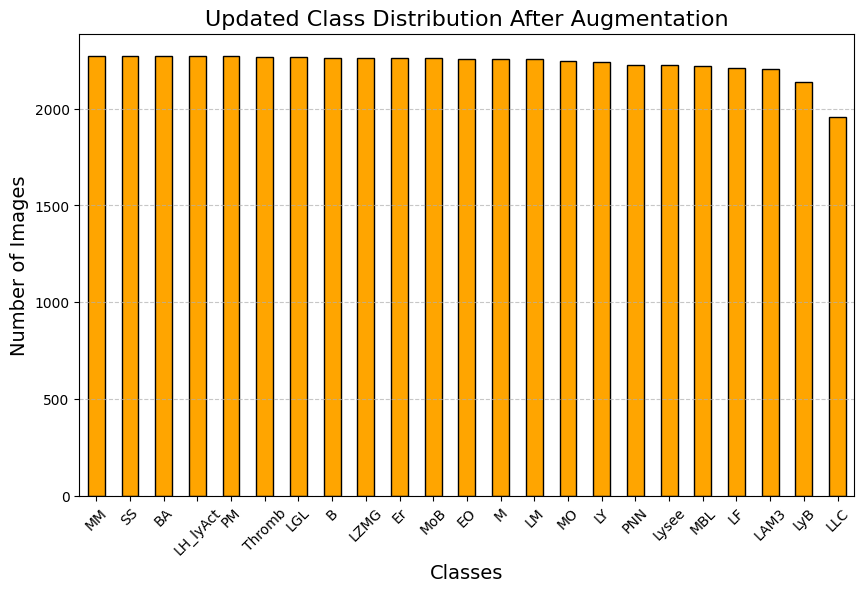

Updated Class Distribution Summary:
class
MM          2275
SS          2275
BA          2274
LH_lyAct    2271
PM          2271
Thromb      2269
LGL         2269
B           2264
LZMG        2264
Er          2263
MoB         2260
EO          2258
M           2257
LM          2255
MO          2247
LY          2240
PNN         2228
Lysee       2227
MBL         2221
LF          2213
LAM3        2206
LyB         2139
LLC         1959


In [25]:
# Load the dataset
df = pd.read_csv(balanced_csv_path)

# Plot the updated class distribution
updated_class_counts = df['class'].value_counts()

plt.figure(figsize=(10, 6))
updated_class_counts.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Updated Class Distribution After Augmentation", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Updated Class Distribution Summary:")
print(updated_class_counts.to_string())

## **4. Splitting the Dataset into Train and Validation Sets**

In this step, we split the augmented and cropped dataset into **training** and **validation** sets using an **80-20 split**:

- **Training Set (80%)**: This set is used to train the model, allowing it to learn the features of the data.
- **Validation Set (20%)**: This set monitors the model's performance during training, helping tune hyperparameters and prevent overfitting. It provides feedback on how well the model generalizes to unseen data.

The **validation set** plays a crucial role in evaluating the model’s ability to perform on data it hasn’t seen before, ensuring it doesn't simply memorize the training data (overfitting). By splitting the dataset, we create an unbiased environment for effective learning and model tuning.

Once the splitting is complete:

- The `training_images` folder will be organized into `train/` and `validation/` directories.
- The `new_Training_data.csv` file will be removed and replaced with two separate CSV files: `train.csv` and `validation.csv`, containing the paths to the images for each set.tion sets.

In [26]:
import os
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the CSV with all images
df = pd.read_csv('balanced_csv.csv')

# Split into train and validation (80-20) while preserving class distribution
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

# Create directories for the training and validation sets
os.makedirs('dataset/images/train', exist_ok=True)
os.makedirs('dataset/images/val', exist_ok=True)

# Function to move images to the target folder
def move_images(df_subset, target_folder):
    moved_images = set()  # Keep track of moved images
    for _, row in df_subset.iterrows():
        image_name = row['NAME']
        source_path = os.path.join('balanced_images', image_name)
        target_path = os.path.join(target_folder, image_name)
        
        # Move the image
        if os.path.exists(source_path):
            shutil.move(source_path, target_path)
            moved_images.add(image_name)  # Mark the image as moved
    
    return moved_images

# Move images for training and validation
train_moved = move_images(train_df, 'dataset/images/train')
val_moved = move_images(val_df, 'dataset/images/val')



# Save the train and validation CSVs
train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('validation_data.csv', index=False)

# Print statistics
print("\n--- Dataset Statistics ---")
print(f"Total images in CSV: {len(df)}")
print(f"Total images in Training Set: {len(train_df)}")
print(f"Total images in Validation Set: {len(val_df)}")
print("\n--------------------------")


--- Dataset Statistics ---
Total images in CSV: 51405
Total images in Training Set: 41124
Total images in Validation Set: 10281

--------------------------


# Training the YOLOv5 Model
This section details the process of training the **YOLO** model, specifically designed for detecting and classifying white blood cells. The methodology begins with preparing the dataset by generating YOLO-compatible annotations, ensuring that each image is linked to a single bounding box and its corresponding class label. Automated Python scripts are utilized to create these annotation files, normalize bounding box coordinates, and define the class structure. A `data.yaml` file is subsequently generated to define the dataset organization, specifying paths for training and validation images, the number of classes, and their respective names.  
This section outlines the steps to:

1. Generate YOLO annotations for the training and validation datasets.
2. Prepare the `data.yaml` file for the YOLOv8 model.
3. Train the YOLOv8 model using the preparedction model.

## 1. Generate YOLO annotations for the training and validation datasets.

In this step, we prepare the dataset for YOLO model training by generating annotations in the required YOLO format. The process involves reading the image metadata (such as class and bounding box coordinates) from CSV files and converting this information into normalized annotations. The bounding box coordinates are normalized according to the image dimensions, and class labels are mapped to corresponding integer IDs. 

For each image, a `.txt` annotation file is created in the appropriate directory, ensuring that the training and validation sets are correctly labeled for the YOLO model. This step is crucial for ensuring that the model can correctly identify and classify the objects in the dataset during training. The function also handles the creation of necessary directories to store the annotations.

Key features:
- Class IDs are mapped to labels.
- Bounding box coordinates are normalized to YOLO format.
- Annotation files are generated for both training and validation datasets.
- Directories for storing annotations are automatically created. 

This ensures that the YOLO model will receive the data in the proper format for effective training and validation..

In [27]:
import os
import pandas as pd
from PIL import Image

# Define the classes
classes = [
    'PNN', 'LAM3', 'Lysee', 'LyB', 'MO', 'LLC', 'MBL', 'LGL', 'EO',
    'Thromb', 'Er', 'B', 'M', 'LY', 'MM', 'LF', 'MoB', 'PM', 'BA',
    'LH_lyAct', 'LM', 'LZMG', 'SS'
]

# Create a mapping from class name to class ID
class_to_id = {cls: idx for idx, cls in enumerate(classes)}

# Function to create YOLO format annotations
def create_yolo_annotations(df, image_dir, labels_dir):
    os.makedirs(labels_dir, exist_ok=True)  # Ensure labels directory exists

    for _, row in df.iterrows():
        class_id = class_to_id[row['class']]  # Get class ID
        image_path = os.path.join(image_dir, row['NAME'])
        
        # Open the image to verify its dimensions
        img = Image.open(image_path)
        width, height = img.size
        
        # Get the bounding box coordinates
        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']
        
        # Convert bounding box coordinates to YOLO format (normalized)
        box_width = (x2 - x1) / width
        box_height = (y2 - y1) / height
        center_x = (x1 + x2) / 2 / width
        center_y = (y1 + y2) / 2 / height
        
        # Create the label file
        label_path = os.path.join(labels_dir, row['NAME'].replace('.jpg', '.txt'))
        with open(label_path, 'w') as f:
            f.write(f"{class_id} {center_x} {center_y} {box_width} {box_height}\n")

# Load the training and validation data
train_df = pd.read_csv('train_data.csv')  # CSV with 'NAME', 'class', 'x1', 'y1', 'x2', 'y2' columns
val_df = pd.read_csv('validation_data.csv')

# Define directories
train_images_dir = 'dataset/images/train'
val_images_dir = 'dataset/images/val'
train_labels_dir = 'dataset/labels/train'
val_labels_dir = 'dataset/labels/val'

# Generate YOLO annotations
create_yolo_annotations(train_df, train_images_dir, train_labels_dir)
create_yolo_annotations(val_df, val_images_dir, val_labels_dir)

print("YOLO annotations generated.")

YOLO annotations generated.


**Visualizing YOLO Annotations**

In this notebook, we've created a script to visualize the YOLO annotations for a random selection of images from the training dataset. The purpose of this visualization is to ensure that the bounding boxes and class labels are correctly applied to the images, as per the YOLO format. By displaying these annotations, we can confirm that the images are ready and accurately labeled for training.

This step is essential before starting the training process because it helps verify that the YOLO model will receive the correct data, ensuring a smooth and effective training phase.

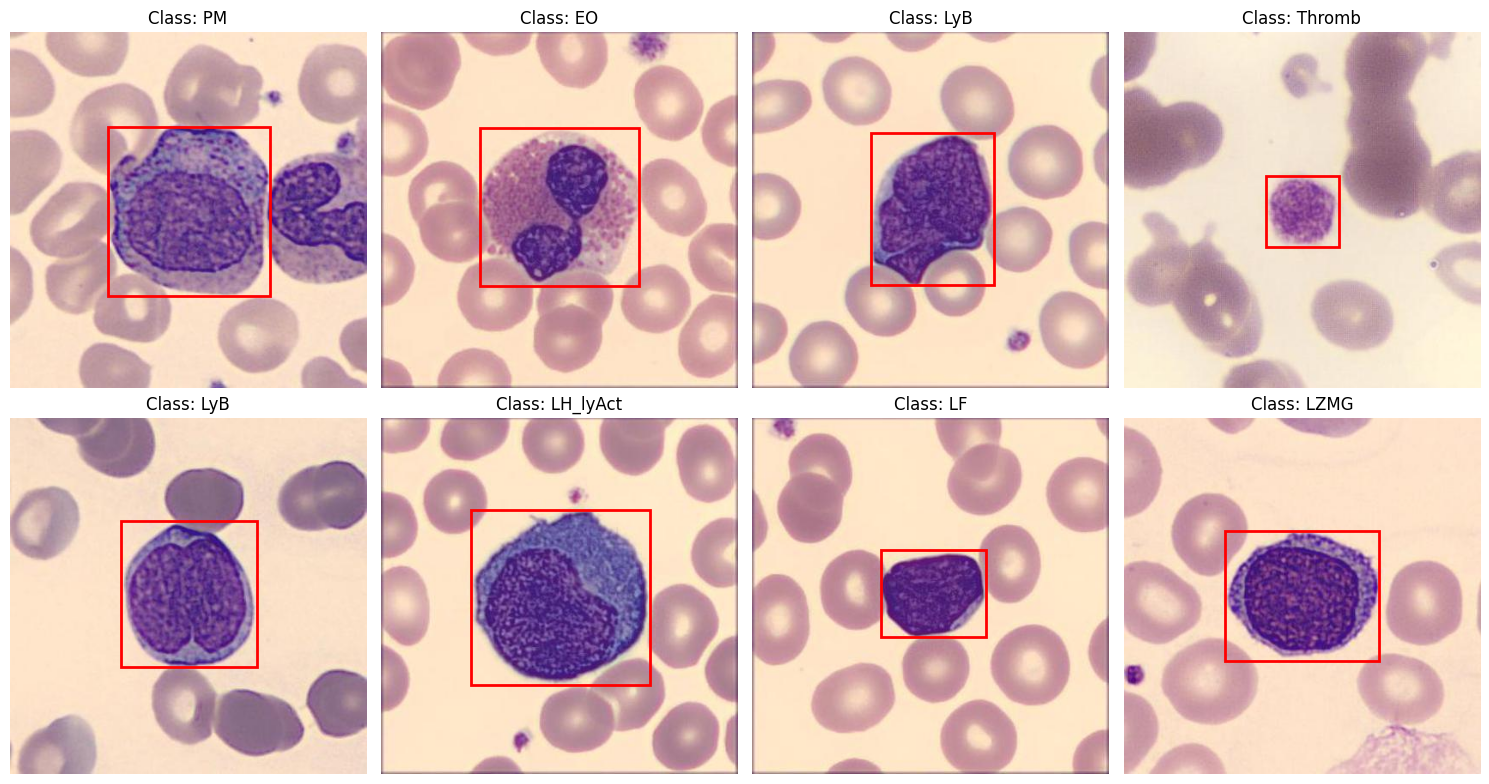

In [28]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Load the training annotations CSV
train_df = pd.read_csv('train_data.csv')

# Randomly select 8 images from the training set
sample_images = random.sample(train_df['NAME'].tolist(), 8)

# Define the image directory
train_images_dir = 'dataset/images/train'

# Set up the grid for displaying images (2 rows, 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(15, 8))

# Iterate through the selected sample images and plot them
for i, ax in enumerate(axes.flat):
    image_name = sample_images[i]
    image_path = os.path.join(train_images_dir, image_name)
    
    # Open the image
    img = Image.open(image_path)
    
    # Plot the image
    ax.imshow(img)
    
    # Get the corresponding annotation data (bounding boxes)
    image_data = train_df[train_df['NAME'] == image_name].iloc[0]
    
    # Get bounding box coordinates and class
    x1, y1, x2, y2 = image_data['x1'], image_data['y1'], image_data['x2'], image_data['y2']
    class_name = image_data['class']
    
    # Draw the bounding box
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    # Set the title with the class name
    ax.set_title(f"Class: {class_name}")
    ax.axis('off')  # Hide axes for better visualization

plt.tight_layout()
plt.show()

Now that we've validated the annotations, we're ready to start training our model with confidence!

## 2. Prepare the `data.yaml` file for the YOLO model.


The YOLOv5 model relies on a `data.yaml` file to configure the dataset structure for training and validation. This file defines:  

- The root directory of the dataset.  
- Paths to training and validation image folders.  
- The list of class names corresponding to object categories in the dataset.  

The structure ensures that the model correctly identifies and uses the dataset for training. Below is an example of the `data.yam loading and utilization during training.

In [29]:
import os

# Base directory
base_dir = "/kaggle/working"

# Define the YAML content as a string
data_yaml = f"""
train: {os.path.join(base_dir, 'dataset/images/train')}
val: {os.path.join(base_dir, 'dataset/images/val')}

nc: 23
names:
  - PNN
  - LAM3
  - Lysee
  - LyB
  - MO
  - LLC
  - MBL
  - LGL
  - EO
  - Thromb
  - Er
  - B
  - M
  - LY
  - MM
  - LF
  - MoB
  - PM
  - BA
  - LH_lyAct
  - LM
  - LZMG
  - SS
"""

# Write the data.yaml file
with open(os.path.join(base_dir, 'data.yaml'), 'w') as f:
    f.write(data_yaml)

print("YOLO Yaml configuration file created.")

YOLO Yaml configuration file created.


### 3. Train the YOLO Model Using the Prepared Dataset

In this cell, we continue the training of a YOLOv5x model using the Ultralytics YOLO library. This step leverages manual checkpointing, allowing the model to resume training from its previously saved state (`last_40epochs.pt`). This approach ensures the model begins from an optimal state, building on prior progress to further refine its accuracy and performance.

#### **Key Components**
1. **Library Import**:
   - `YOLO` is imported from the `ultralytics` library, which provides a streamlined interface for training and deploying YOLOv5 models.

2. **Model Loading**:
   - The YOLOv5x model is loaded using the checkpoint file `last_40epochs.pt`. This file represents the trained weights from the previous 40 epochs, allowing us to continue training without starting from scratch.

3. **Training Configuration**:
   - **Data Configuration**: The `data.yaml` file, located in the specified directory, defines the dataset structure, including training and validation paths and class definitions.
   - **Epochs**: The model is trained for an additional 20 epochs to further optimize its performance.
   - **Batch Size**: A batch size of 16 is used, balancing computational efficiency and gradient accuracy.

4. **Training Execution**:
   - The `.train()` method initiates the training process using the defined configuration. This step fine-tunes the model parameters to improve detection accuracy on the target dataset.

This continuation of training ensures the model achieves a higher level of optimization, leveraging both prior training progress and additional learning iterations for enhanced object detection capabilities.

### Getting the trained model

In [30]:
!gdown --id  1lrs5MaGv_RGQYwXL-DUR96lpm14aneKI #yolov5m trained 

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1lrs5MaGv_RGQYwXL-DUR96lpm14aneKI
From (redirected): https://drive.google.com/uc?id=1lrs5MaGv_RGQYwXL-DUR96lpm14aneKI&confirm=t&uuid=3317e8f2-0773-4ae6-a51d-d2f1e77ef023
To: /kaggle/working/lastv5_40epochs.pt
100%|███████████████████████████████████████| 50.5M/50.5M [00:00<00:00, 101MB/s]


In [31]:
from ultralytics import YOLO
import os

# Base directory
base_dir = "/kaggle/working"

# Load the YOLOv5x model
model = YOLO('lastv5_40epochs.pt') 

# Train the model
model.train(
    data=os.path.join(base_dir, 'data.yaml'),  # Path to dataset configuration file
    epochs=20,            # Number of training epochs
    batch=16            # Batch size
)

print("Model training completed!")


Ultralytics 8.3.60 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=lastv5_40epochs.pt, data=/kaggle/working/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

100%|██████████| 755k/755k [00:00<00:00, 17.3MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1      5280  ultralytics.nn.modules.conv.Conv             [3, 48, 6, 2, 2]              
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2     65280  ultralytics.nn.modules.block.C3              [96, 96, 2]                   
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    444672  ultralytics.nn.modules.block.C3              [192, 192, 4]                 
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  6   2512896  ultralytics.nn.modules.block.C3              [384, 384, 6]                 
  7                  -1  1   2655744  ultralytics.nn.modules.conv.Conv             [384

100%|██████████| 5.35M/5.35M [00:00<00:00, 72.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/labels/train... 41124 images, 0 backgrounds, 30 corrupt: 100%|██████████| 41124/41124 [00:34<00:00, 1185.06it/s]

train: WARNING ⚠️ /kaggle/working/dataset/images/train/0dbab3f6-c_1.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1466       1.274]
train: WARNING ⚠️ /kaggle/working/dataset/images/train/20a37946-6_1.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2127]
train: WARNING ⚠️ /kaggle/working/dataset/images/train/24654883-1_1.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3125]
train: WARNING ⚠️ /kaggle/working/dataset/images/train/3c2739ef-9_1.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1875]
train: WARNING ⚠️ /kaggle/working/dataset/images/train/3d7abaa2-3_1.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.149]
train: WARNING ⚠️ /kaggle/working/dataset/images/train/43775dd3-9_1.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0252       1.262]
train: WAR

train: New cache created: /kaggle/working/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset/labels/val... 10281 images, 0 backgrounds, 10 corrupt: 100%|██████████| 10281/10281 [00:08<00:00, 1158.55it/s]

val: WARNING ⚠️ /kaggle/working/dataset/images/val/5e9f7daa-3_1.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2404]
val: WARNING ⚠️ /kaggle/working/dataset/images/val/76c5163b-5_1.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0168]
val: WARNING ⚠️ /kaggle/working/dataset/images/val/ba4b58dc-4_1.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2212      1.0805]
val: WARNING ⚠️ /kaggle/working/dataset/images/val/be7a9bd7-e_1.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1154      1.1971]
val: WARNING ⚠️ /kaggle/working/dataset/images/val/c6b6a2c7-8_1.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1719]
val: WARNING ⚠️ /kaggle/working/dataset/images/val/ca5669c0-f_1.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1418      1.1683]
val: WARNING ⚠️ /kaggl

val: New cache created: /kaggle/working/dataset/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 91 weight(decay=0.0), 98 weight(decay=0.0005), 97 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.73G     0.4296     0.6031     0.9742         13        640: 100%|██████████| 2569/2569 [21:02<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:11<00:00,  2.45it/s]

                   all      10271      10271      0.893      0.827      0.899      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.58G     0.4394     0.6032     0.9743         15        640: 100%|██████████| 2569/2569 [20:55<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.47it/s]

                   all      10271      10271      0.859      0.825      0.888      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.66G     0.4605     0.6876     0.9842         12        640: 100%|██████████| 2569/2569 [20:50<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.46it/s]

                   all      10271      10271       0.85      0.799      0.872      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.66G     0.4872     0.7824     0.9966         10        640: 100%|██████████| 2569/2569 [20:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.47it/s]

                   all      10271      10271       0.83      0.799      0.864      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.81G     0.4847     0.7646     0.9952         10        640: 100%|██████████| 2569/2569 [20:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.47it/s]

                   all      10271      10271      0.863      0.805      0.875      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.58G     0.4798     0.7449     0.9951          8        640: 100%|██████████| 2569/2569 [20:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.46it/s]

                   all      10271      10271      0.854      0.809      0.877      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.84G     0.4736     0.7239     0.9917         14        640: 100%|██████████| 2569/2569 [20:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.47it/s]

                   all      10271      10271      0.855      0.829      0.888       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.67G     0.4691     0.6983     0.9874         12        640: 100%|██████████| 2569/2569 [20:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.46it/s]

                   all      10271      10271      0.866      0.821      0.891      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.66G     0.4605     0.6834     0.9845         14        640: 100%|██████████| 2569/2569 [20:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.46it/s]

                   all      10271      10271      0.868      0.823      0.893      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.59G     0.4531     0.6581     0.9822         12        640: 100%|██████████| 2569/2569 [20:45<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.47it/s]

                   all      10271      10271      0.882      0.827      0.895      0.849


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.67G     0.3583     0.5239     0.9234          6        640: 100%|██████████| 2569/2569 [20:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.46it/s]

                   all      10271      10271      0.877      0.836      0.901      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.82G     0.3501      0.498     0.9175          6        640: 100%|██████████| 2569/2569 [20:39<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.47it/s]

                   all      10271      10271      0.878      0.839      0.902      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.65G     0.3443     0.4724     0.9121          6        640: 100%|██████████| 2569/2569 [20:39<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.46it/s]

                   all      10271      10271      0.883      0.847      0.904      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.58G     0.3378     0.4545     0.9083          6        640: 100%|██████████| 2569/2569 [20:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.47it/s]

                   all      10271      10271       0.89      0.838      0.906      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.67G     0.3311     0.4292     0.9018          6        640: 100%|██████████| 2569/2569 [20:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.47it/s]

                   all      10271      10271      0.893      0.834      0.907      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.65G     0.3261     0.4076     0.8975          6        640: 100%|██████████| 2569/2569 [20:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.46it/s]

                   all      10271      10271      0.887      0.844      0.907      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.82G     0.3172     0.3814     0.8915          6        640: 100%|██████████| 2569/2569 [20:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.46it/s]

                   all      10271      10271      0.883      0.849      0.907      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.57G     0.3103     0.3608     0.8875          6        640: 100%|██████████| 2569/2569 [20:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.46it/s]

                   all      10271      10271      0.889      0.844      0.907      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.66G     0.3023     0.3385     0.8834          6        640: 100%|██████████| 2569/2569 [20:42<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.46it/s]

                   all      10271      10271        0.9      0.837      0.906      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.66G     0.2969     0.3212     0.8781          6        640: 100%|██████████| 2569/2569 [20:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.46it/s]

                   all      10271      10271        0.9      0.836      0.906      0.868



20 epochs completed in 7.648 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 50.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 50.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.60 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5m summary (fused): 248 layers, 25,058,533 parameters, 0 gradients, 64.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 321/321 [02:10<00:00,  2.47it/s]


                   all      10271      10271      0.889      0.844      0.907      0.869
                   PNN        445        445      0.975       0.96       0.98      0.963
                  LAM3        441        441      0.942      0.889      0.965      0.949
                 Lysee        444        444      0.959      0.896      0.951      0.848
                   LyB        428        428      0.899      0.813      0.915      0.899
                    MO        448        448      0.942      0.913      0.962      0.933
                   LLC        392        392      0.831      0.688      0.833      0.802
                   MBL        444        444      0.727      0.772      0.821      0.795
                   LGL        454        454      0.873      0.894      0.924      0.874
                    EO        451        451      0.966       0.94      0.983      0.959
                Thromb        454        454      0.941      0.908      0.951      0.744
                    E

## Model Performance Evaluation

This section evaluates the model's performance, displaying key metrics like precision, recall, F1-score, and mAP over the training epochs. Visualizations such as performance curves and loss plots are included, along with the model's configuration parameters from the `args.yaml` file, providing a clear overview of the model's effectiveness.


Final Metrics (Last Epoch):


epoch                   20.000000
metrics/precision(B)     0.899810
metrics/recall(B)        0.836060
metrics/mAP50(B)         0.906000
metrics/mAP50-95(B)      0.867900
F1_score                 0.866764
Name: 19, dtype: float64


Intersection over Union (IoU): 0.8679
IoU measures the overlap between predicted and ground-truth bounding boxes, ensuring accurate localization.


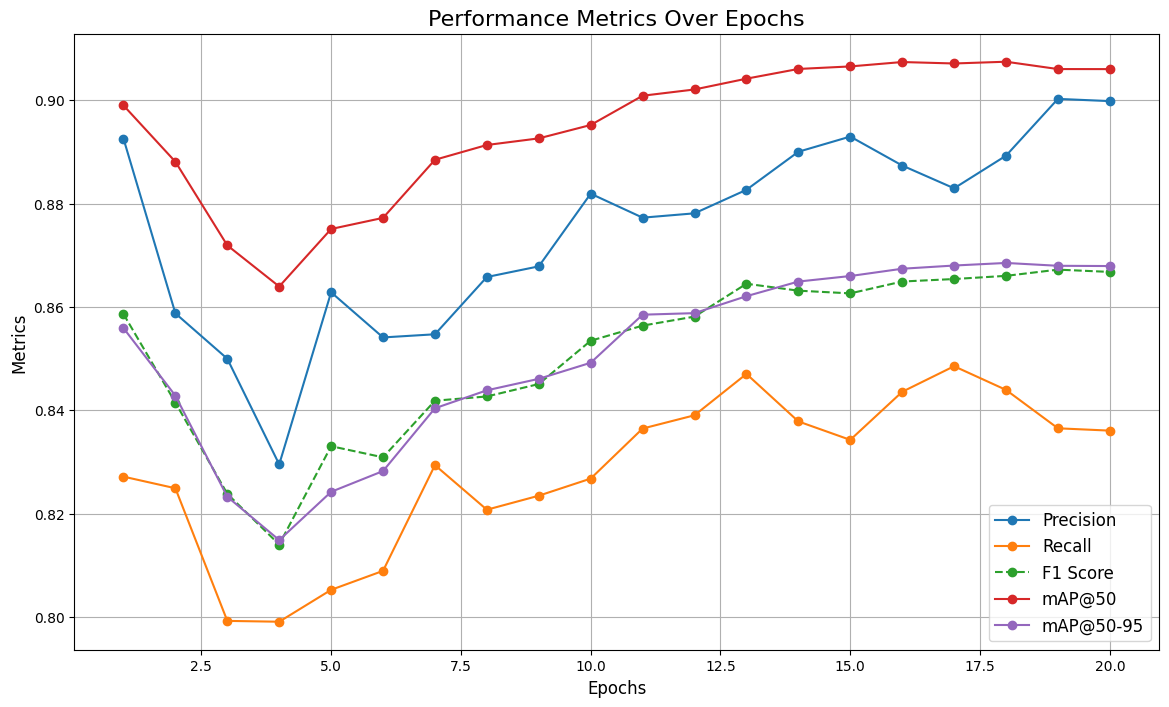

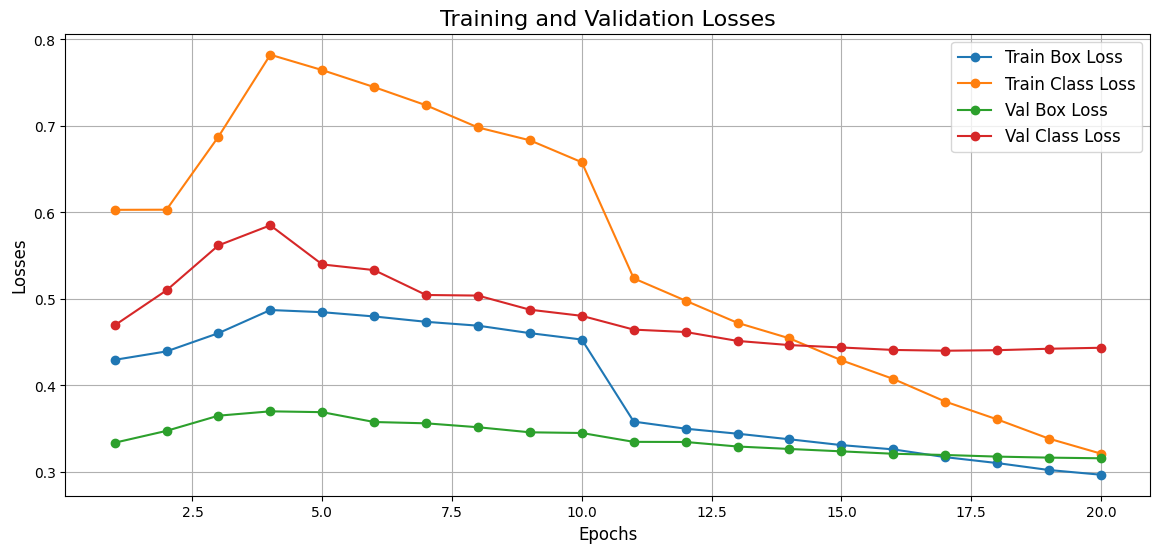


Displaying: results.png


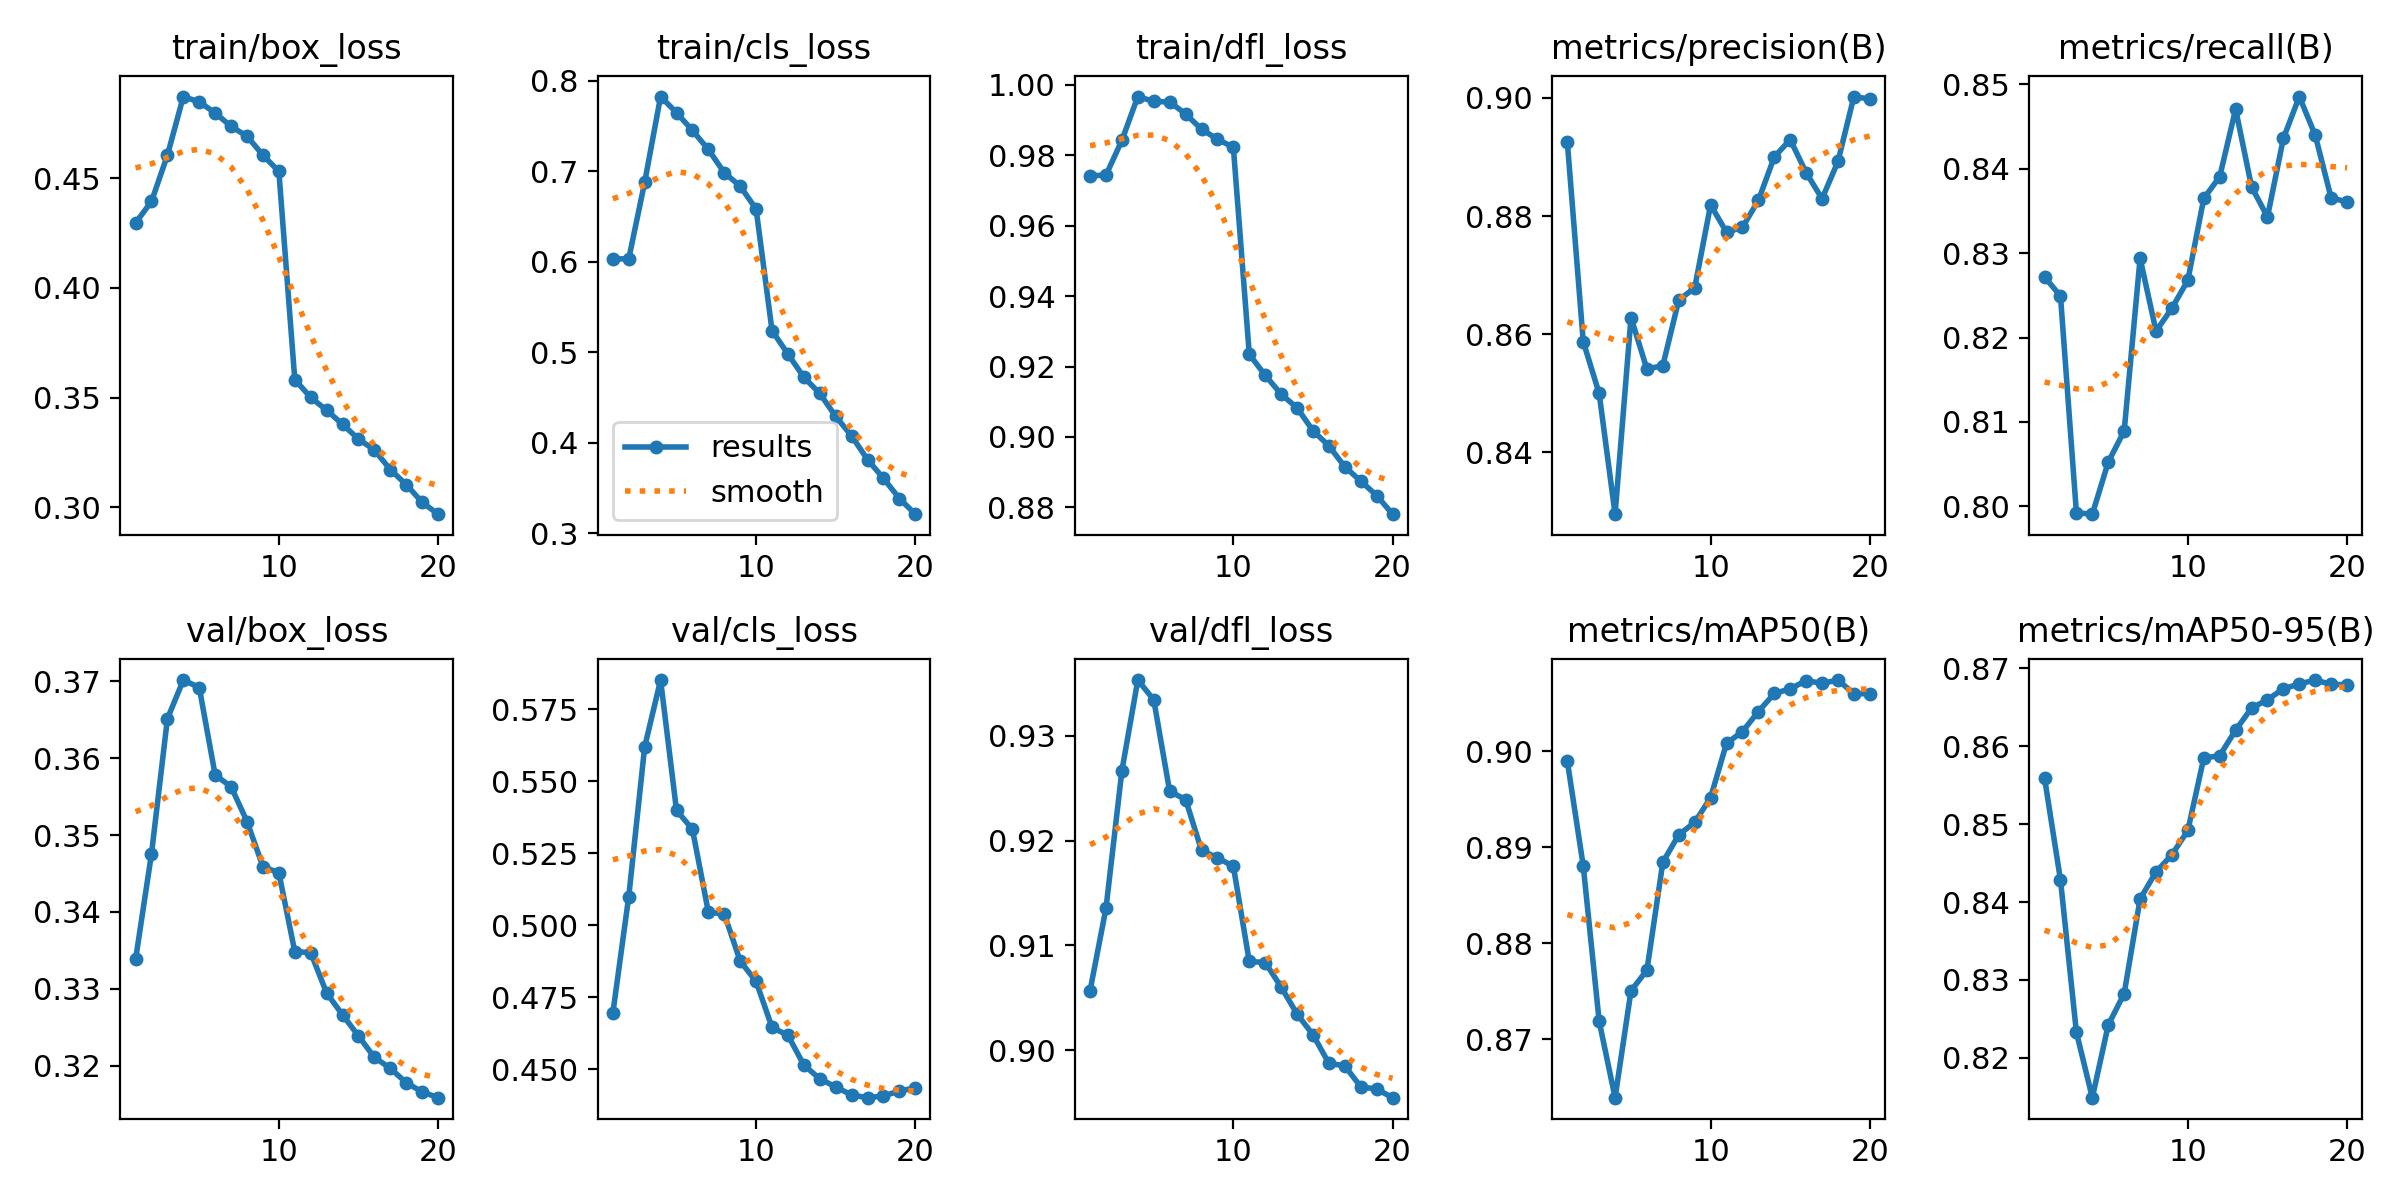


Displaying: F1_curve.png


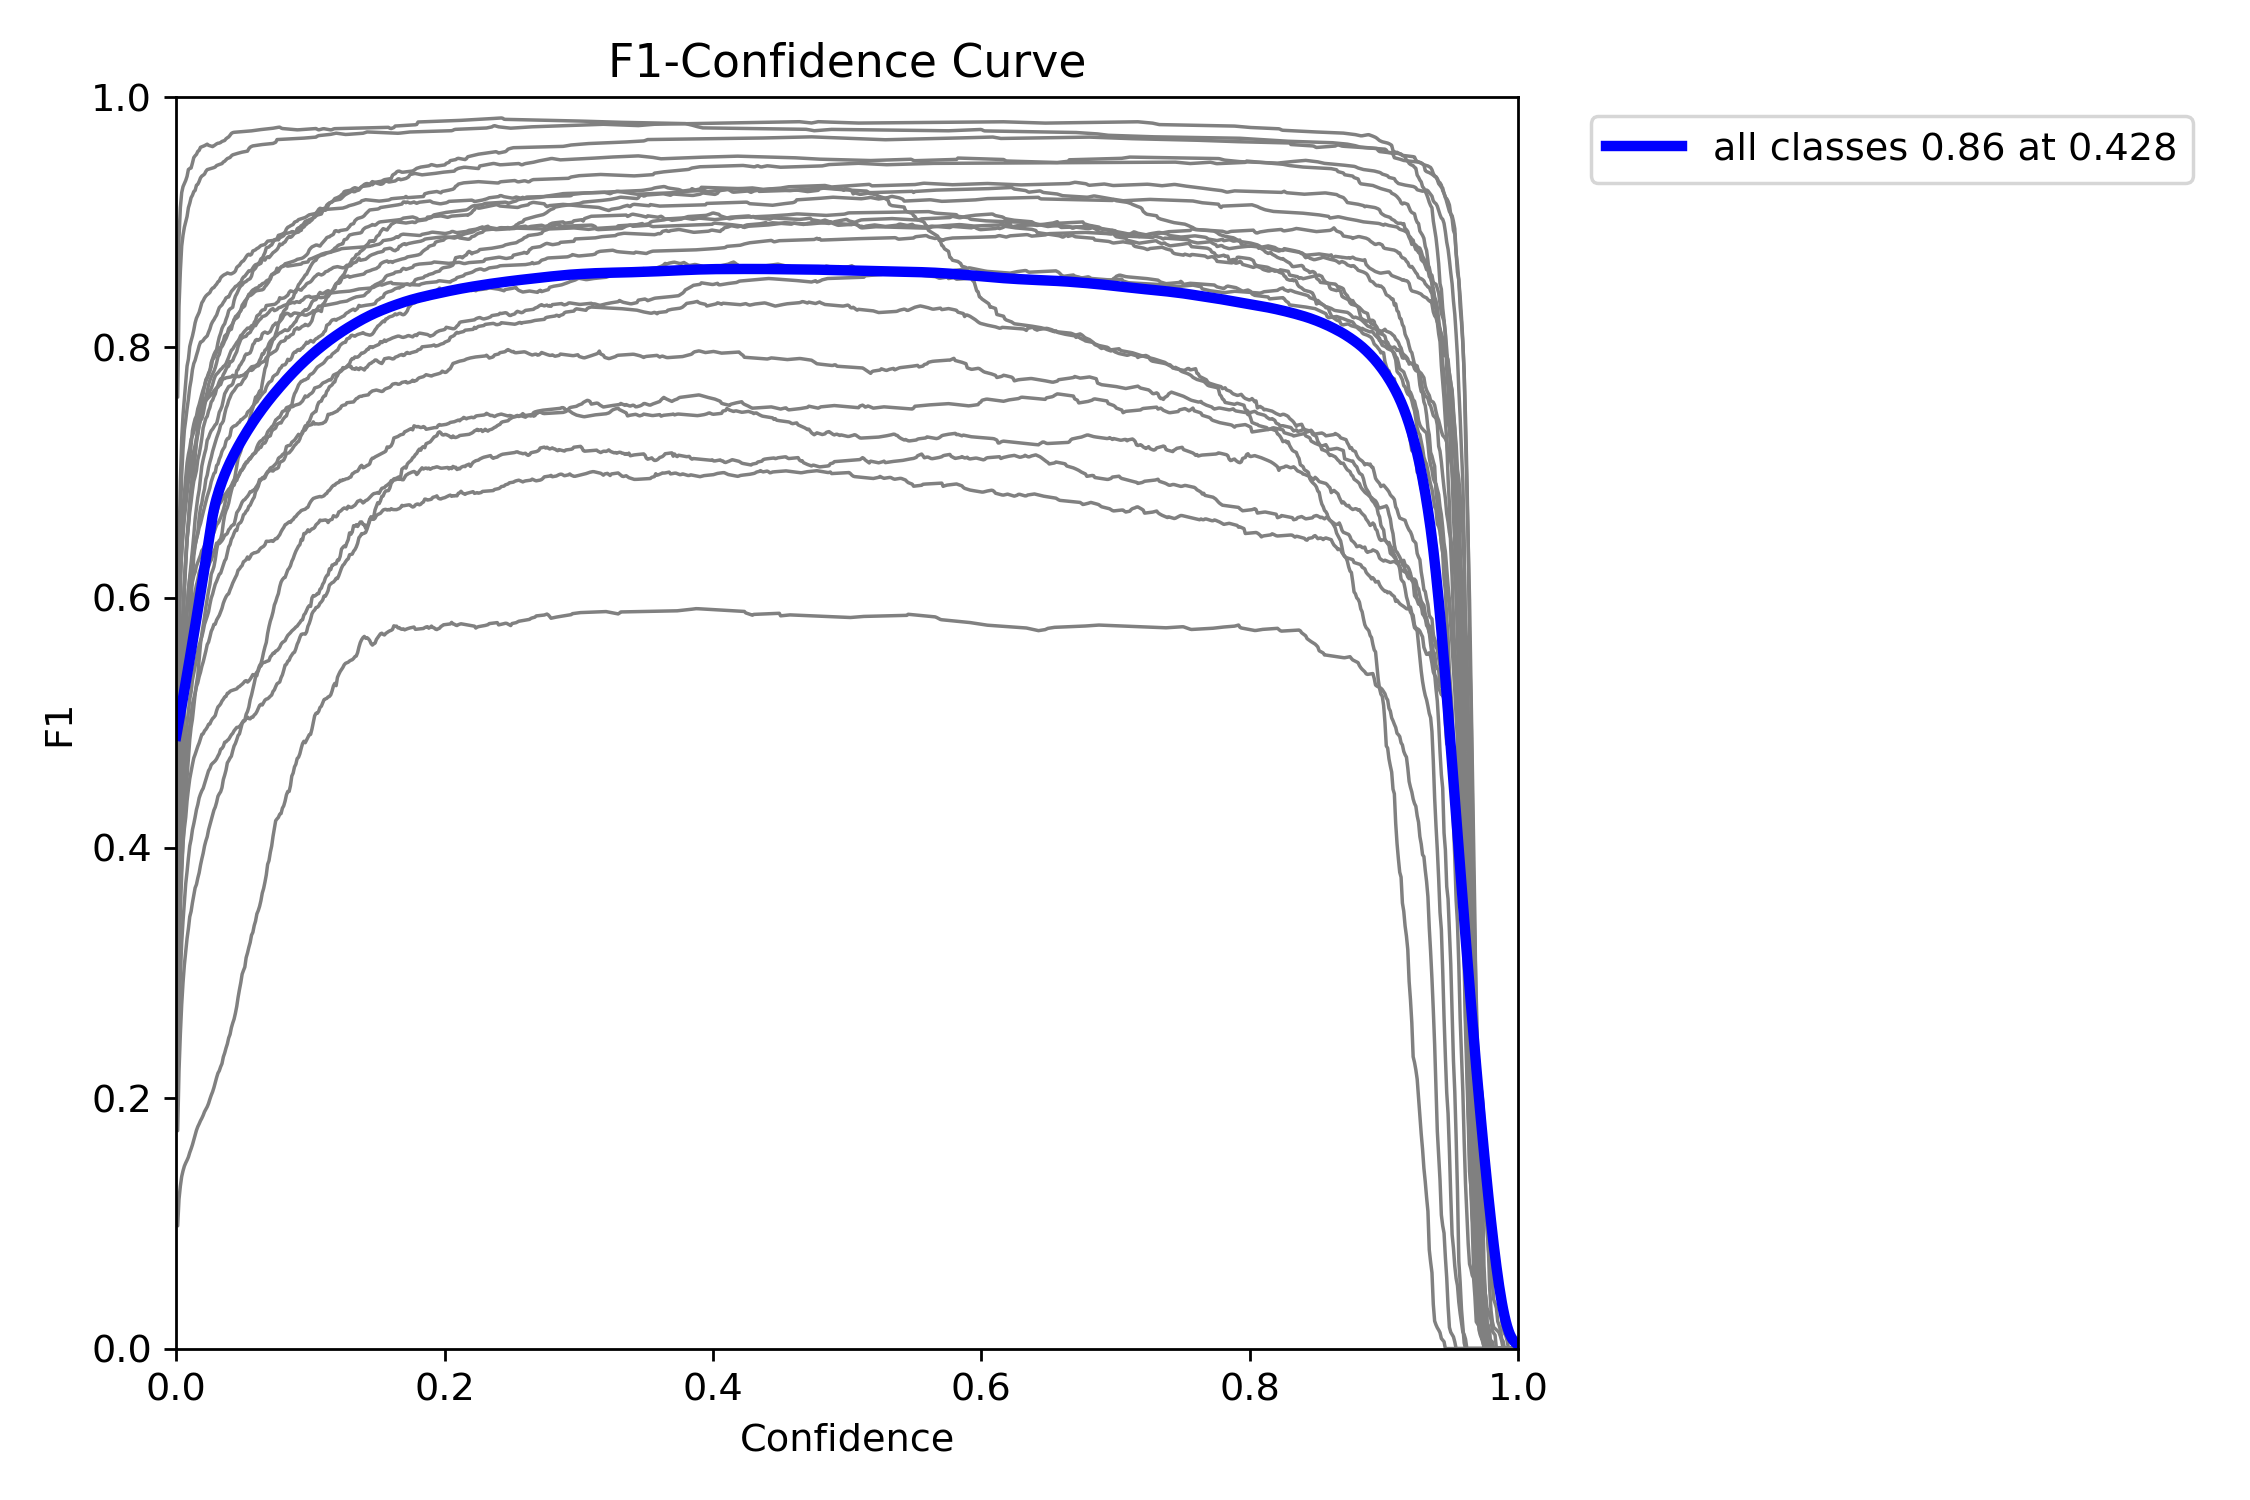


Displaying: P_curve.png


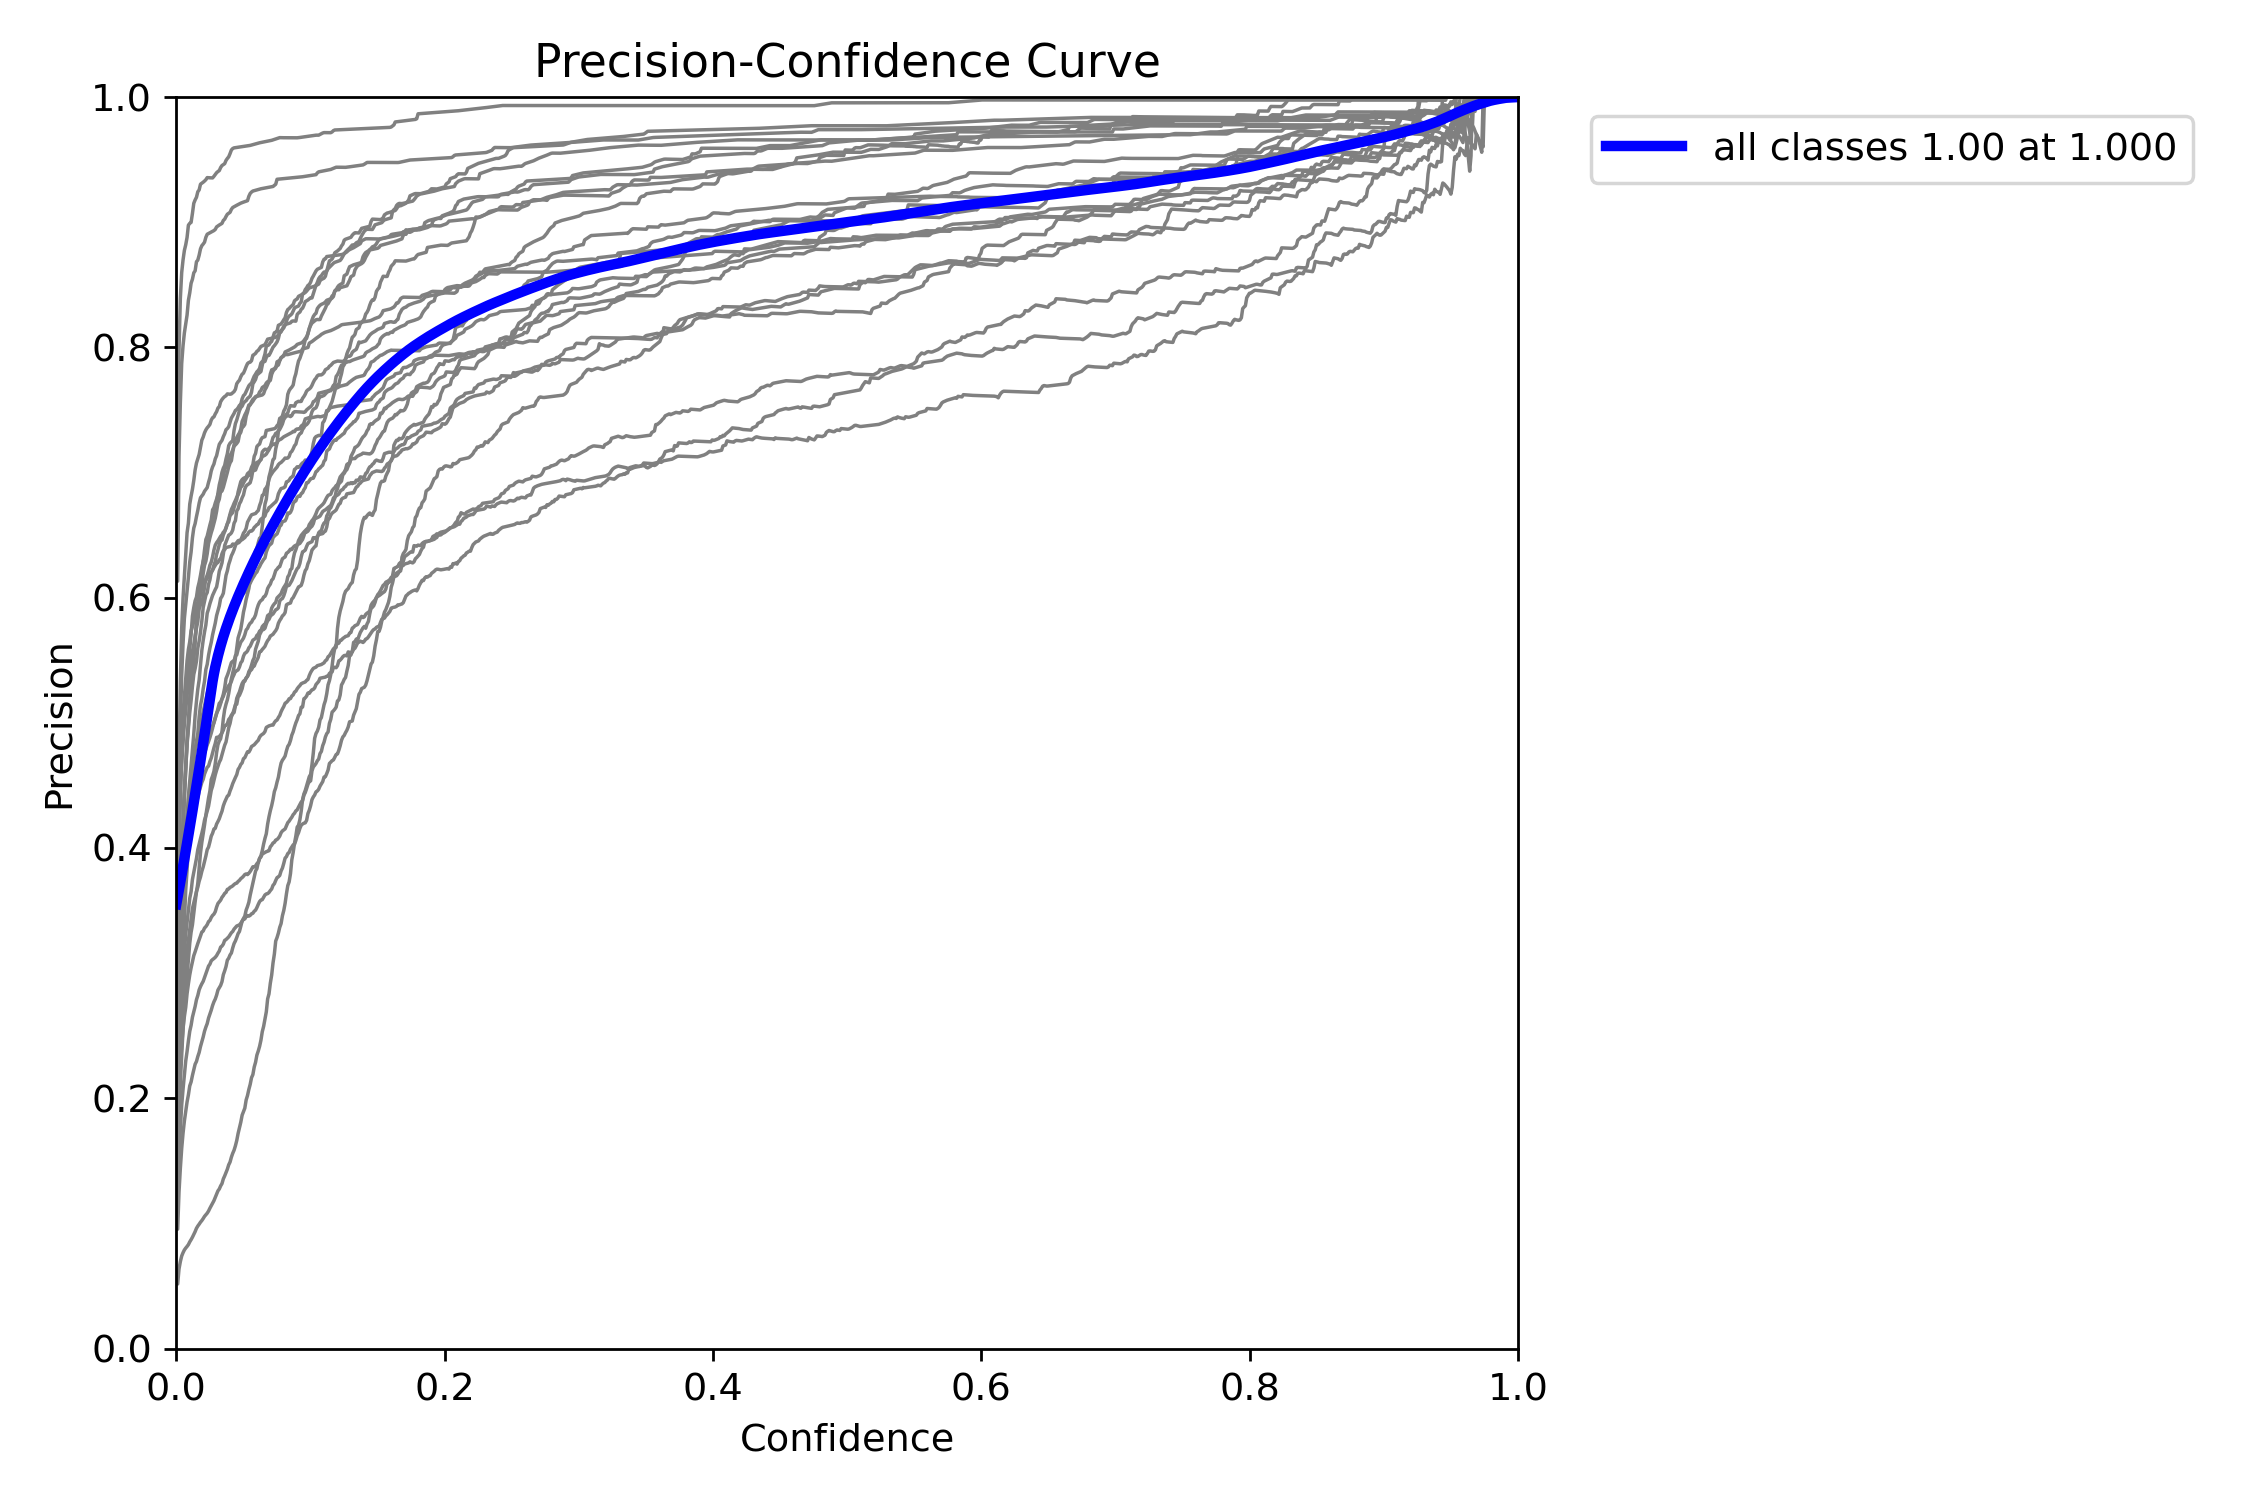


Displaying: PR_curve.png


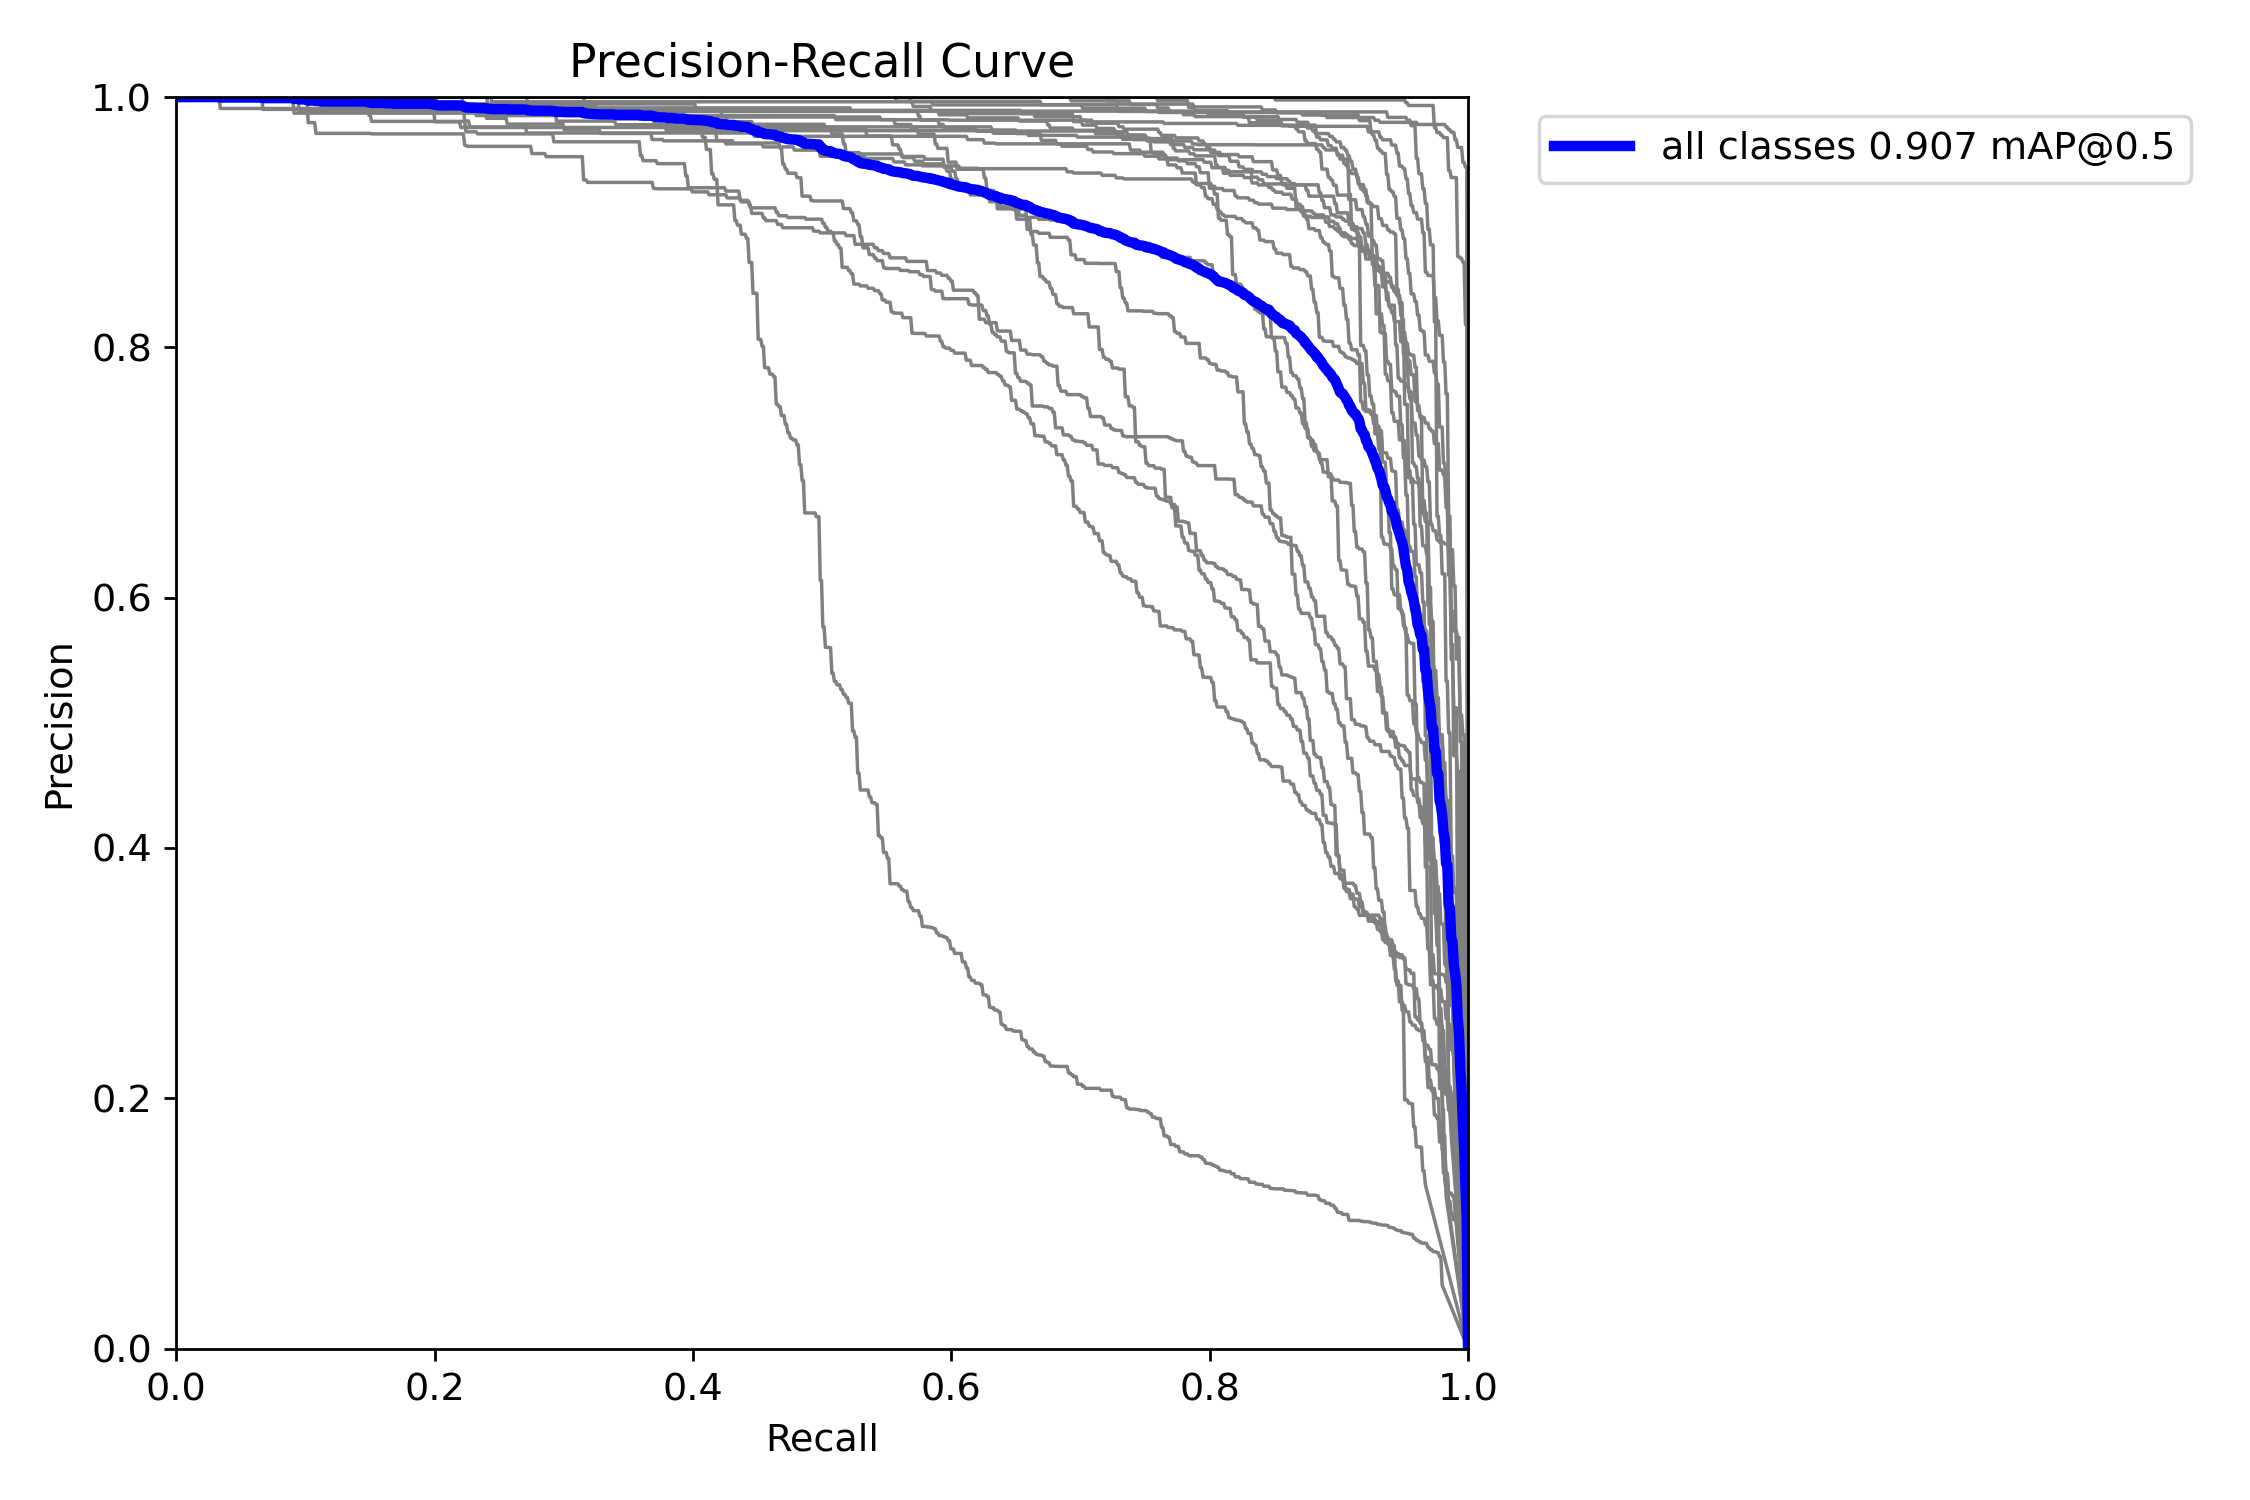


Displaying: R_curve.png


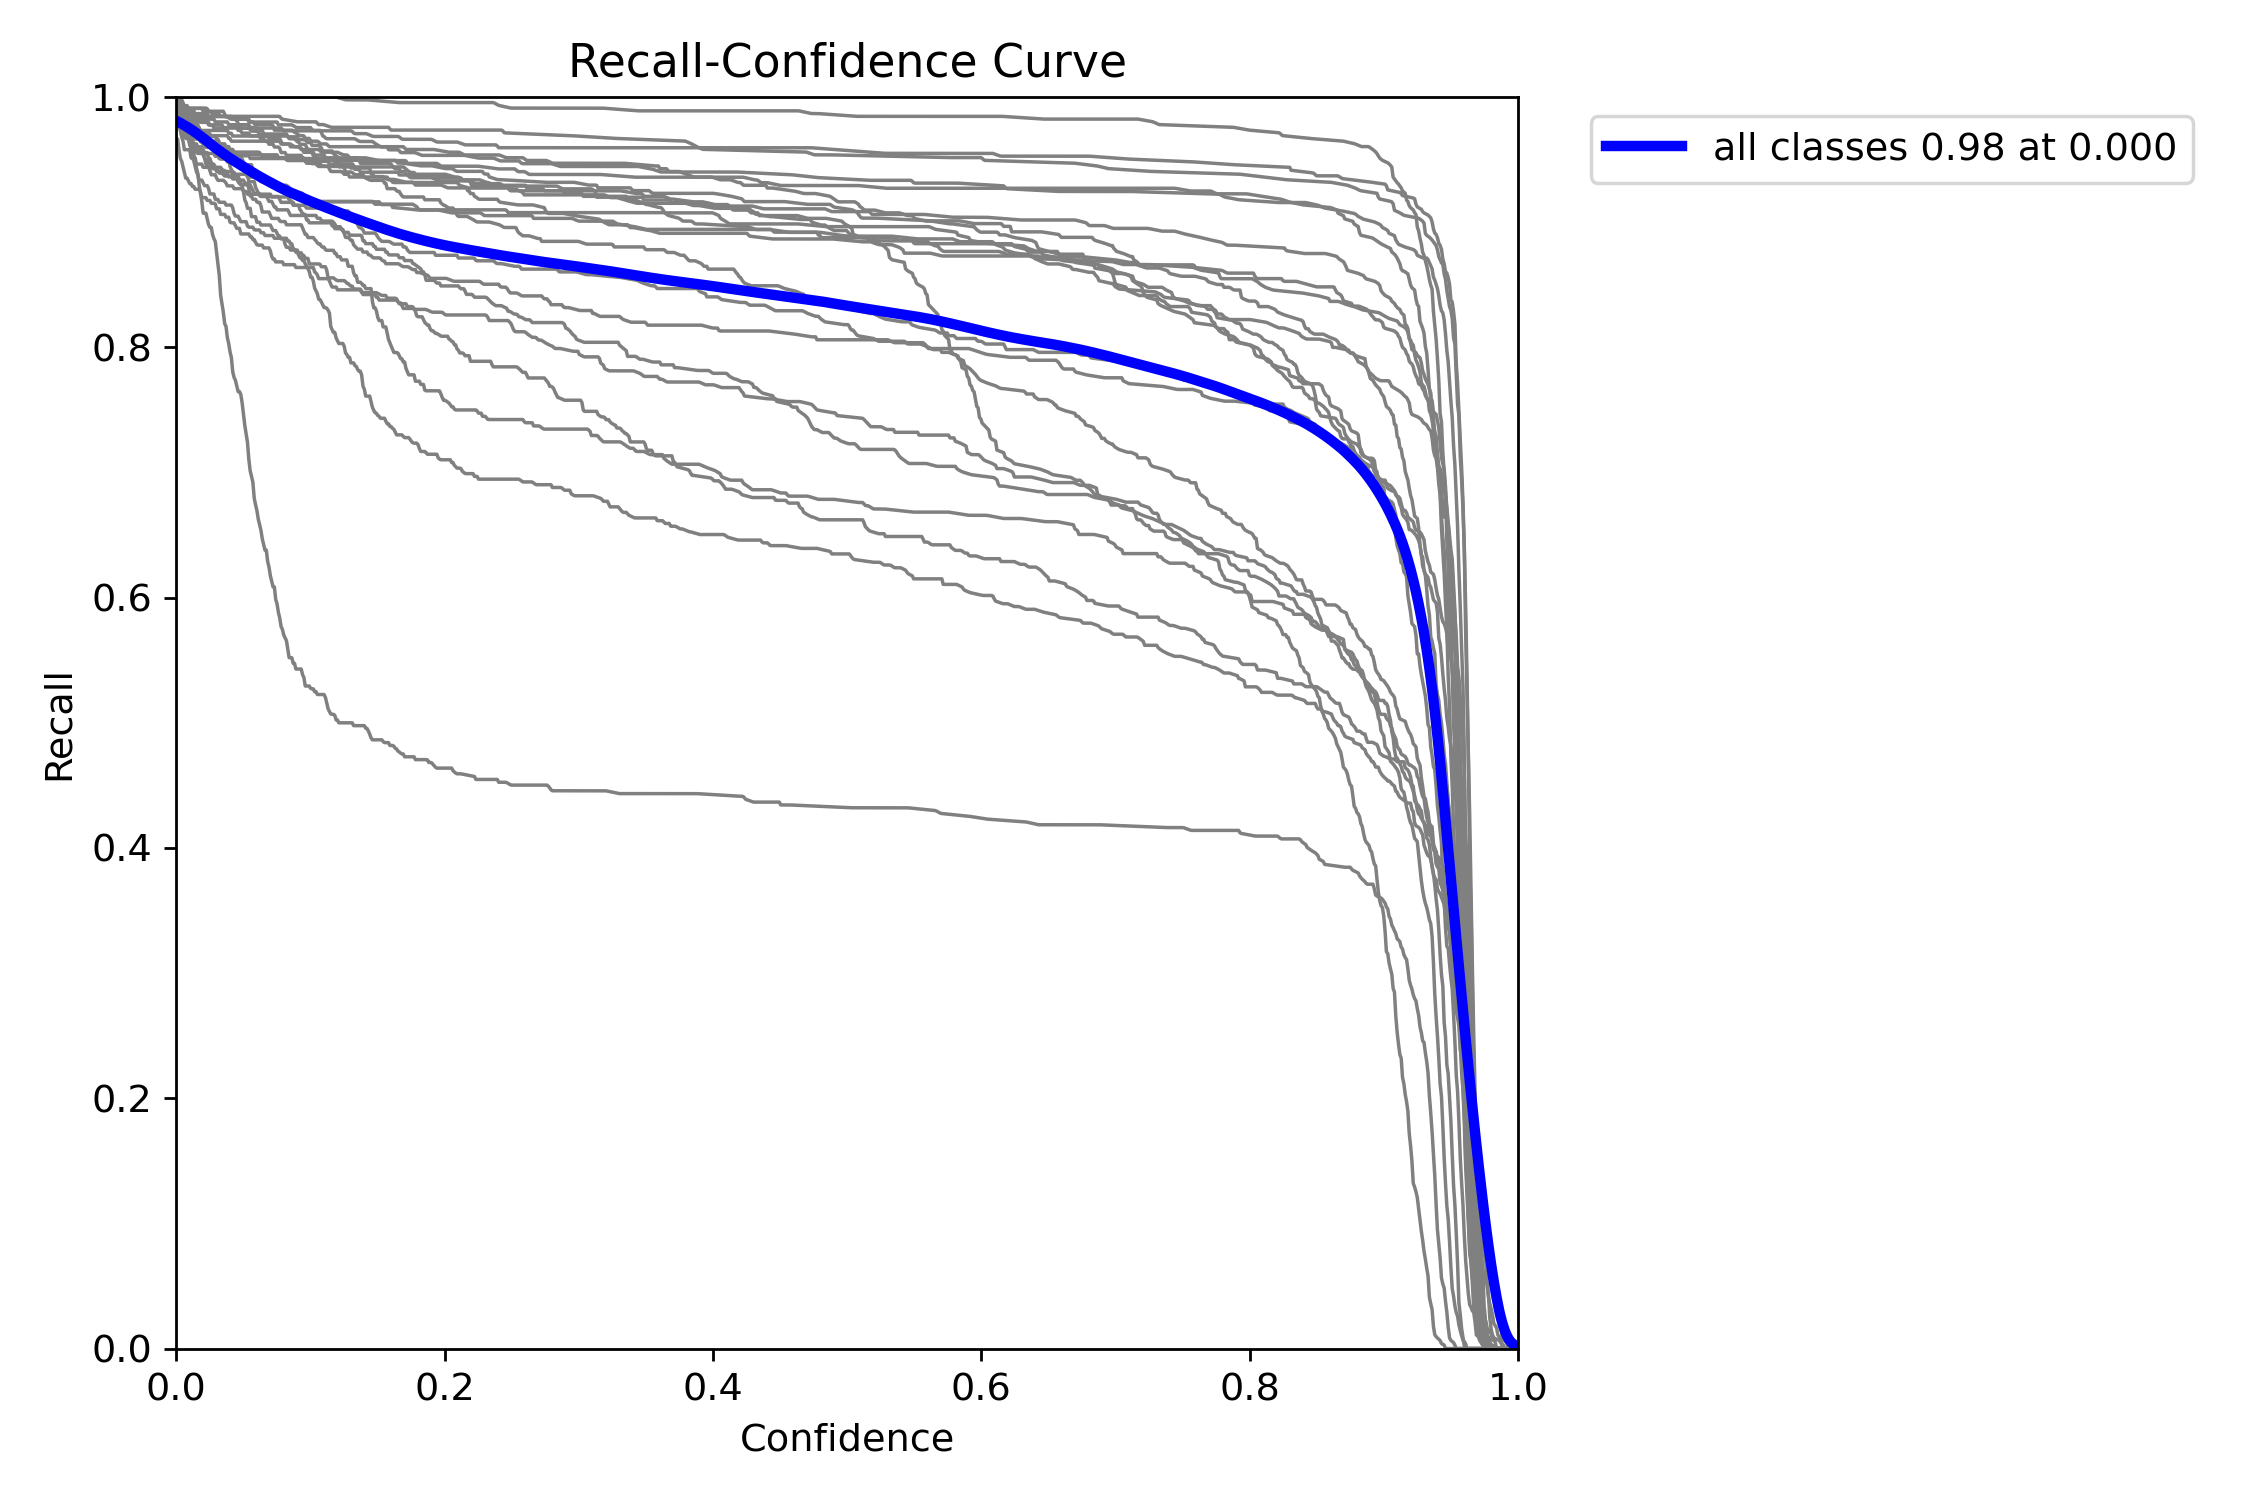


Model Configuration (Important Parameters):


{'epochs': '20', 'batch': '16', 'imgsz': '640', 'optimizer': 'auto'}

In [32]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Path to the training results directory
results_dir = "runs/detect/train"

# Load the results CSV
results_csv_path = os.path.join(results_dir, "results.csv")
if os.path.exists(results_csv_path):
    # Read the CSV into a DataFrame
    results_df = pd.read_csv(results_csv_path)

    # Calculate F1-Score (2 * Precision * Recall / (Precision + Recall))
    results_df['F1_score'] = 2 * results_df['metrics/precision(B)'] * results_df['metrics/recall(B)'] / \
                             (results_df['metrics/precision(B)'] + results_df['metrics/recall(B)'])

    # Calculate Intersection over Union (IoU) as mAP50-95 is closely related to IoU
    iou = results_df['metrics/mAP50-95(B)'].iloc[-1]  # Using mAP50-95 as an IoU proxy

    # Display Final Metrics
    print("\nFinal Metrics (Last Epoch):")
    final_metrics = results_df.iloc[-1][['epoch', 'metrics/precision(B)', 'metrics/recall(B)', 
                                         'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'F1_score']]
    display(final_metrics)

    # Display Calculated IoU
    print(f"\nIntersection over Union (IoU): {iou:.4f}")
    print("IoU measures the overlap between predicted and ground-truth bounding boxes, ensuring accurate localization.")

    # Plot Key Metrics Over Epochs
    plt.figure(figsize=(14, 8))
    plt.plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Precision', marker='o')
    plt.plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Recall', marker='o')
    plt.plot(results_df['epoch'], results_df['F1_score'], label='F1 Score', marker='o', linestyle='--')
    plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP@50', marker='o')
    plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP@50-95', marker='o')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Metrics', fontsize=12)
    plt.title('Performance Metrics Over Epochs', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # Plot Losses Over Epochs
    plt.figure(figsize=(14, 6))
    plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss', marker='o')
    plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Train Class Loss', marker='o')
    plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Val Box Loss', marker='o')
    plt.plot(results_df['epoch'], results_df['val/cls_loss'], label='Val Class Loss', marker='o')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Losses', fontsize=12)
    plt.title('Training and Validation Losses', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # Display Results Images (e.g., F1 Curve, Precision-Recall Curve, Results Overview)
    images_to_display = ["results.png", "F1_curve.png", "P_curve.png", "PR_curve.png", "R_curve.png"]
    for img_name in images_to_display:
        img_path = os.path.join(results_dir, img_name)
        if os.path.exists(img_path):
            print(f"\nDisplaying: {img_name}")
            display(Image(filename=img_path, width=800))
        else:
            print(f"Image {img_name} not found in {results_dir}")

else:
    print(f"Results CSV not found at {results_csv_path}. Ensure training is completed and metrics are saved.")

# Extract Important Data from args.yaml
args_path = os.path.join(results_dir, "args.yaml")
if os.path.exists(args_path):
    print("\nModel Configuration (Important Parameters):")
    important_args = {}
    with open(args_path, 'r') as file:
        for line in file:
            if ":" in line:
                key, value = map(str.strip, line.split(":", 1))
                important_args[key] = value
    # Display only key parameters like imgsz , batch , epochs(even though this model is pretraiend by us several spearated times with more epochs)
    display({k: v for k, v in important_args.items() if k in ["imgsz", "epochs", "batch", "optimizer"]})
else:
    print("\nConfiguration file (args.yaml) not found.")

## Title: Save the Trained YOLOv5 Model as `final_YOLO.pt`

This code takes the trained YOLOv5 model (`best.pt`) from the training results directory and saves it as `final_YOLO.pt` in the current working directory. By copying the model file to the running directory, it ensures the model is easily accessible for further use, such as deployment or inference tasks.

In [33]:
import shutil

# Path to the trained model
model_path = "runs/detect/train/weights/best.pt"

# Path to save the model in the running directory
final_model_path = "final_YOLO.pt"

# Copy the model to the desired location
shutil.copy(model_path, final_model_path)


'final_YOLO.pt'